# Exploring the Israel–Palestine Reddit Dataset
_made by Ocheretianyi Hlieb and Sukhodolskyi Dmytro_

## Dataset overview (basic metrics)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
from paths import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from datetime import datetime
import igraph as ig
from collections import defaultdict

In [ ]:
nltk.download('vader_lexicon')

In [ ]:
df_comments = pd.read_csv(OUTPUT_PATH / 'joined_comments.csv')
df_submissions = pd.read_csv(OUTPUT_PATH / 'joined_submissions.csv')

In [5]:
df_comments.head()

,author,subreddit,score,created,link,body
0,u/lisztomania_0,AskMiddleEast,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/AskMiddleEast/comment...,It is an über talent that has become an über t...
1,u/JakeTheSandMan,worldnews,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/worldnews/comments/15...,“Armada” \n\nI prefer to call them floating hu...
2,u/justnmirrrs,worldnews,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/worldnews/comments/15...,"70% of France electricity is nuclear, so it co..."
3,u/liquid_cherry,worldnews,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/worldnews/comments/15...,In the United States you can burn the Bible an...
4,u/Grouchy-Bad-4190,AskMiddleEast,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/AskMiddleEast/comment...,Good


In [6]:
df_submissions.head()

,author,subreddit,title,num_comments,score,over_18,created,link,text,url
0,u/BurstYourBubbles,worldnews,"S. Korean, Italian FMs hold talks on boosting ...",0.000150,0.000019,False,2023-08-01 03:24,https://www.reddit.com/r/worldnews/comments/15...,NaN,https://en.yna.co.kr/view/AEN20230801001000325?
1,u/BurstYourBubbles,worldnews,Hong Kong gov't would face 'difficulty' if it ...,0.000075,0.000019,False,2023-08-01 03:26,https://www.reddit.com/r/worldnews/comments/15...,NaN,https://hongkongfp.com/2023/08/01/hong-kong-go...
2,u/kurdishgun,AskMiddleEast,Thoughts on exmuslim?,0.004198,0.000019,False,2023-08-01 03:31,https://www.reddit.com/r/AskMiddleEast/comment...,NaN,https://i.redd.it/mmy60for8efb1.png
3,u/TypicalHorror9,worldnews,Professional dancer pumping gas in NYC stabbed...,0.000000,0.000019,False,2023-08-01 03:41,https://www.reddit.com/r/worldnews/comments/15...,NaN,https://www.nydailynews.com/new-york/nyc-crime...
4,u/mrwhiskeyrum,worldnews,Frequent dispatch of ships and aircraft by cer...,0.000899,0.000019,False,2023-08-01 03:44,https://www.reddit.com/r/worldnews/comments/15...,NaN,https://newsinfo.inquirer.net/1809492/foreign-...


Adding additional columns for further analysis

In [49]:
sia = SentimentIntensityAnalyzer()

df_comments['compound'] = df_comments['body'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

df_submissions['compound'] = df_submissions['title'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

from urllib.parse import urlparse

df_submissions['domain'] = df_submissions['url'].apply(lambda x: urlparse(str(x)).netloc if pd.notnull(x) else '')

# Для тесту
df_submissions[['subreddit','url','domain']].head()

In [6]:
df_comments.head()

,author,subreddit,score,created,link,body,compound
0,u/lisztomania_0,AskMiddleEast,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/AskMiddleEast/comment...,It is an über talent that has become an über t...,0.5611
1,u/JakeTheSandMan,worldnews,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/worldnews/comments/15...,“Armada” \n\nI prefer to call them floating hu...,0.0000
2,u/justnmirrrs,worldnews,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/worldnews/comments/15...,"70% of France electricity is nuclear, so it co...",0.5879
3,u/liquid_cherry,worldnews,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/worldnews/comments/15...,In the United States you can burn the Bible an...,0.6369
4,u/Grouchy-Bad-4190,AskMiddleEast,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/AskMiddleEast/comment...,Good,0.4404


In [7]:
df_submissions.head()

,author,subreddit,title,num_comments,score,over_18,created,link,text,url,domain
0,u/BurstYourBubbles,worldnews,"S. Korean, Italian FMs hold talks on boosting ...",0.000150,0.000019,False,2023-08-01 03:24,https://www.reddit.com/r/worldnews/comments/15...,NaN,https://en.yna.co.kr/view/AEN20230801001000325?,en.yna.co.kr
1,u/BurstYourBubbles,worldnews,Hong Kong gov't would face 'difficulty' if it ...,0.000075,0.000019,False,2023-08-01 03:26,https://www.reddit.com/r/worldnews/comments/15...,NaN,https://hongkongfp.com/2023/08/01/hong-kong-go...,hongkongfp.com
2,u/kurdishgun,AskMiddleEast,Thoughts on exmuslim?,0.004198,0.000019,False,2023-08-01 03:31,https://www.reddit.com/r/AskMiddleEast/comment...,NaN,https://i.redd.it/mmy60for8efb1.png,i.redd.it
3,u/TypicalHorror9,worldnews,Professional dancer pumping gas in NYC stabbed...,0.000000,0.000019,False,2023-08-01 03:41,https://www.reddit.com/r/worldnews/comments/15...,NaN,https://www.nydailynews.com/new-york/nyc-crime...,www.nydailynews.com
4,u/mrwhiskeyrum,worldnews,Frequent dispatch of ships and aircraft by cer...,0.000899,0.000019,False,2023-08-01 03:44,https://www.reddit.com/r/worldnews/comments/15...,NaN,https://newsinfo.inquirer.net/1809492/foreign-...,newsinfo.inquirer.net


In [9]:
df_comments.shape

(7877798, 7)

In [10]:
df_submissions.shape

(217057, 11)

In [14]:
df_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7877798 entries, 0 to 7877797
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   author     object 
 1   subreddit  object 
 2   score      float64
 3   created    object 
 4   link       object 
 5   body       object 
 6   compound   float64
dtypes: float64(2), object(5)
memory usage: 420.7+ MB


In [15]:
df_submissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217057 entries, 0 to 217056
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   author        217057 non-null  object 
 1   subreddit     217057 non-null  object 
 2   title         217057 non-null  object 
 3   num_comments  217057 non-null  float64
 4   score         217057 non-null  float64
 5   over_18       217057 non-null  bool   
 6   created       217057 non-null  object 
 7   link          217057 non-null  object 
 8   text          71473 non-null   object 
 9   url           213512 non-null  object 
 10  domain        213240 non-null  object 
dtypes: bool(1), float64(2), object(8)
memory usage: 16.8+ MB


In [17]:
print("Comments timeframe:", df_comments['created'].min(), "->", df_comments['created'].max())
print("Submissions timeframe:", df_submissions['created'].min(), "->", df_submissions['created'].max())

Comments timeframe: 2023-08-01 03:00:00 -> 2024-03-01 01:59:00
Submissions timeframe: 2023-08-01 03:24 -> 2024-03-01 01:59


## Activity and distribution


### 1. Correlation: Israel-Gaza Conflict and r/worldnews Commenting Activity

Those charts track the daily volume of unique comments posted on the r/worldnews subreddit. They highlight a strong and direct correlation between a major geopolitical event and online engagement.

First one shows the total daily volume of all unique comments submitted to the r/worldnews subreddit, regardless of topic, demonstrating the overall community reaction to the crisis.

The second chart (below) refines this view by only including comments that explicitly mention keywords related to the conflict (Gaza, Palestine, Israel, Hamas), thereby isolating the volume of discussion specifically centered on this event.


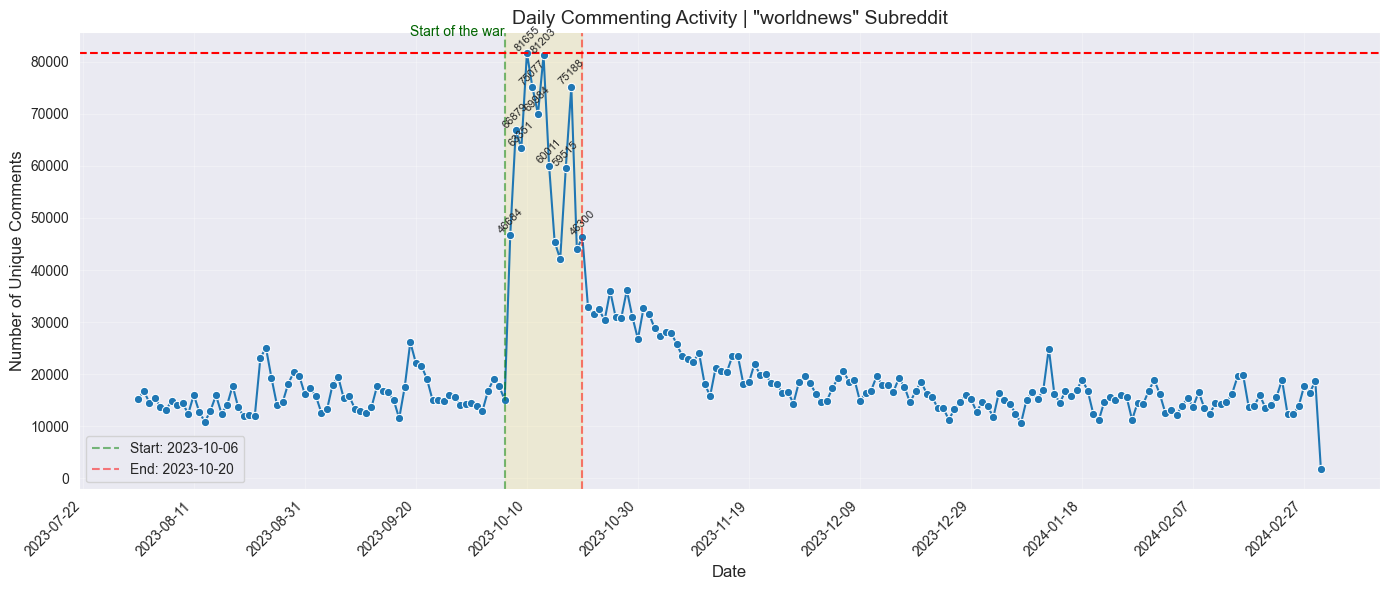

In [7]:
filtered_df = df_comments[df_comments['subreddit'] == 'worldnews'].copy()
filtered_df = filtered_df.drop_duplicates(subset=['author', 'body'], keep='first')

filtered_df['date'] = pd.to_datetime(filtered_df['created']).dt.date

daily_counts = filtered_df['date'].value_counts().sort_index()
daily_counts_df = daily_counts.reset_index()
daily_counts_df.columns = ['Date', 'Comment_Count']

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='Comment_Count', data=daily_counts_df, marker='o')

threshold = daily_counts_df['Comment_Count'].quantile(0.95)

above_threshold = daily_counts_df[daily_counts_df['Comment_Count'] > threshold]

first_date = above_threshold['Date'].min() - timedelta(days=1)
last_date = above_threshold['Date'].max()

plt.axvline(first_date, color='green', linestyle='--', alpha=0.5, label=f'Start: {first_date}')
plt.axvline(last_date, color='red', linestyle='--', alpha=0.5, label=f'End: {last_date}')
plt.axvspan(first_date, last_date, color='khaki', alpha=0.3)

plt.text(first_date, daily_counts_df['Comment_Count'].max() * 1.05, 'Start of the war',
         color='darkgreen', ha='right', va='center', fontsize=10, rotation=0)

for idx, row in daily_counts_df.iterrows():
    if row['Comment_Count'] > threshold:
        plt.text(row['Date'], row['Comment_Count'], str(row['Comment_Count']),
                ha='center', va='bottom', fontsize=8, rotation=45)

plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))  # Max 15 date labels
plt.axhline(y=daily_counts_df['Comment_Count'].max(), color='r', linestyle='--')

plt.title('Daily Commenting Activity | "worldnews" Subreddit', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Unique Comments', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plt.show()

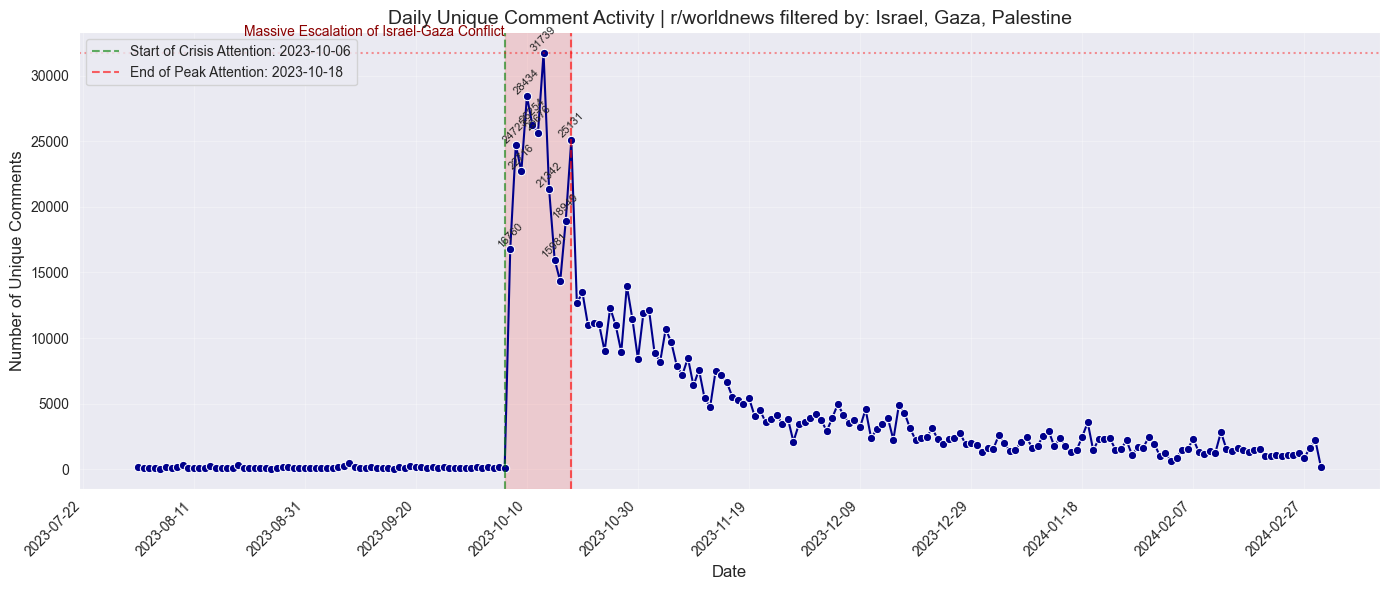

In [8]:
keywords = 'Gaza|Palestine|Israel|Hamas'

# Filtration
filtered_df = df_comments[
    (df_comments['subreddit'] == 'worldnews') &
    (df_comments['body'].str.contains(keywords, case=False, na=False))
].copy()

# date -> datetime
filtered_df['date'] = pd.to_datetime(filtered_df['created']).dt.date

# Unique comments count
daily_counts = filtered_df['date'].value_counts().sort_index()
daily_counts_df = daily_counts.reset_index()
daily_counts_df.columns = ['Date', 'Comment_Count']

# Visualisation
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='Comment_Count', data=daily_counts_df, marker='o', color='darkblue')

threshold = daily_counts_df['Comment_Count'].quantile(0.95)
above_threshold = daily_counts_df[daily_counts_df['Comment_Count'] > threshold]

if not above_threshold.empty:
    first_date = above_threshold['Date'].min() - timedelta(days=1)
    last_date = above_threshold['Date'].max()

    plt.axvline(first_date, color='green', linestyle='--', alpha=0.6, label=f'Start of Crisis Attention: {first_date}')
    plt.axvline(last_date, color='red', linestyle='--', alpha=0.6, label=f'End of Peak Attention: {last_date}')
    plt.axvspan(first_date, last_date, color='lightcoral', alpha=0.3)

    max_y = daily_counts_df['Comment_Count'].max()
    plt.text(first_date, max_y * 1.05, 'Massive Escalation of Israel-Gaza Conflict',
             color='darkred', ha='right', va='center', fontsize=10, rotation=0)

    for idx, row in daily_counts_df.iterrows():
        if row['Comment_Count'] > threshold:
            plt.text(row['Date'], row['Comment_Count'], str(row['Comment_Count']),
                    ha='center', va='bottom', fontsize=8, rotation=45)
else:
    print("Warning: Not enough data points exceeded the 95th percentile threshold to highlight a period.")


plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))

plt.axhline(y=daily_counts_df['Comment_Count'].max(), color='red', linestyle=':', alpha=0.4)

plt.title('Daily Unique Comment Activity | r/worldnews filtered by: Israel, Gaza, Palestine', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Unique Comments', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

#### Most Active Subreddits and Authors
a) Top Active Subreddits

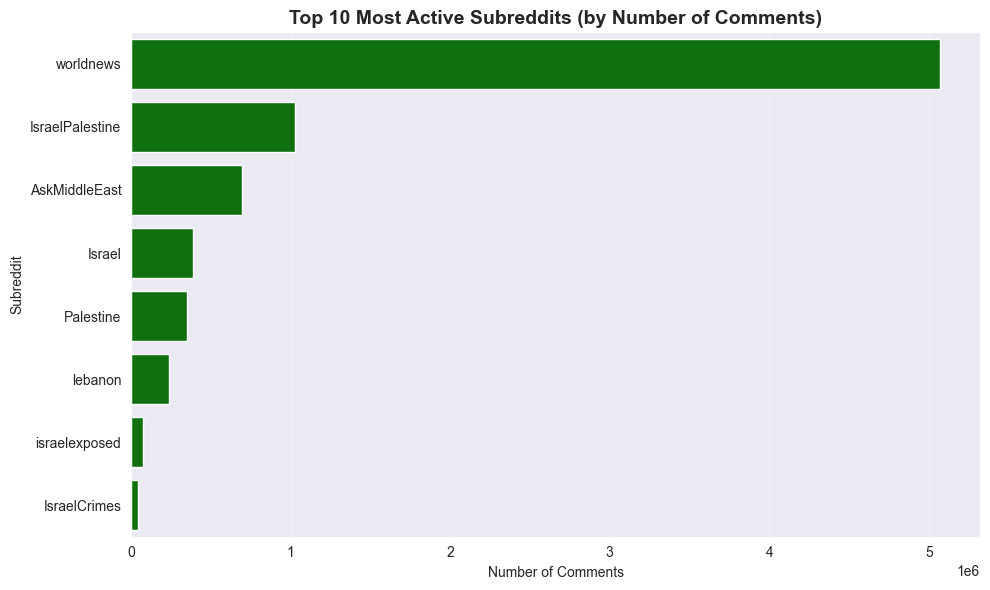

In [21]:
top_subs = (
    df_comments['subreddit']
    .value_counts()
    .head(10)
    .reset_index()
    .rename(columns={'index': 'subreddit', 'subreddit': 'count'})
)

top_subs.columns = ['subreddit', 'count']

plt.figure(figsize=(10, 6))
sns.barplot(data=top_subs, x='count', y='subreddit', color="green")
plt.title("Top 10 Most Active Subreddits (by Number of Comments)", fontsize=14, weight='bold')
plt.xlabel("Number of Comments")
plt.ylabel("Subreddit")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

b) Top Active Authors

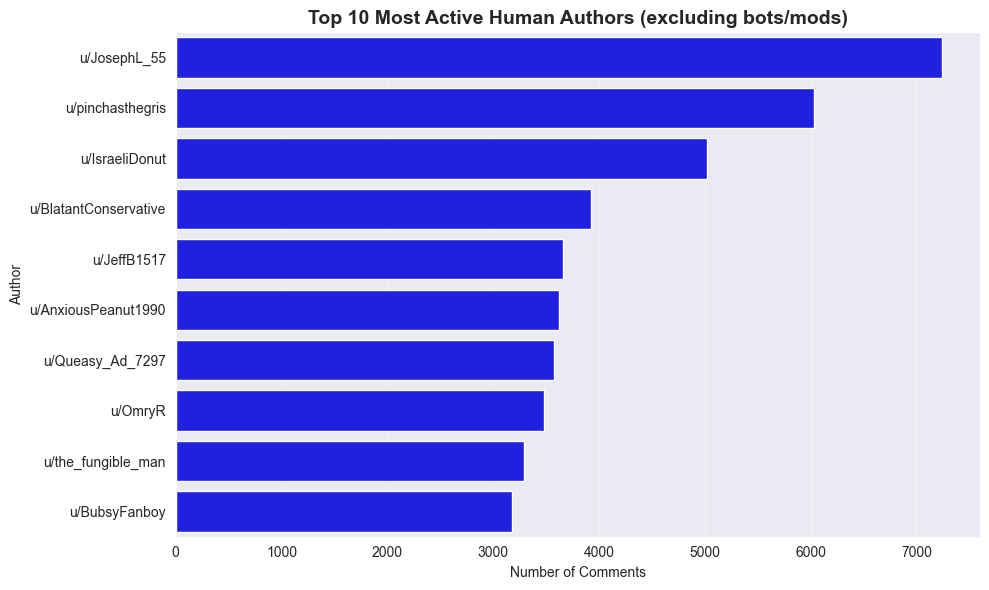

In [25]:
filtered_authors = df_comments[
    ~df_comments['author'].isin([
        'u/[deleted]', 'u/AutoModerator', 'u/Israel-ModTeam',
        'u/Palestine-ModTeam', 'u/ModTeam'
    ])
].copy()

top_authors_clean = (
    filtered_authors['author']
    .value_counts()
    .head(10)
    .reset_index()
    .rename(columns={'index': 'author', 'author': 'count'})
)

top_authors_clean.columns = ['author', 'count']

plt.figure(figsize=(10, 6))
sns.barplot(data=top_authors_clean, x='count', y='author', color='blue')
plt.title("Top 10 Most Active Human Authors (excluding bots/mods)", fontsize=14, weight='bold')
plt.xlabel("Number of Comments")
plt.ylabel("Author")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Content analysis & Interesting findings

#### 1. Sentiment Analysis of r/worldnews Discussions: "Israel" vs. "Palestine"

This line chart visualizes the Daily Average Compound Sentiment for comments on the r/worldnews subreddit, filtered for the keywords "Israel" and "Palestine," starting October 1, 2023. The Compound Sentiment ranges from -1 (most negative) to +1 (most positive).

**Key Timeline Markers:**

War Start (Oct 7, 2023): Marked by a vertical dashed red line, this point signifies the beginning of the major escalation of the conflict.

First 2 Weeks of War (Oct 7 - Oct 21): Shaded in light coral, this area highlights the sentiment during the initial, most intense phase of the conflict.

Zero Line (0.0): A horizontal dashed gray line separates overall positive sentiment (above) from negative sentiment (below).

**Observation:**

Based on the sustained trend following the initial shock, discussions containing the keyword "Israel" (blue line) trended at an equally negative or slightly more negative average compound sentiment than those containing "Palestine" (red line) throughout the majority of the subsequent two weeks.

This suggests that, for the extended period following the initial escalation, commentary in r/worldnews associated with "Israel" was frequently marked by a more critical, angry, or pessimistic tone compared to discussions involving "Palestine."

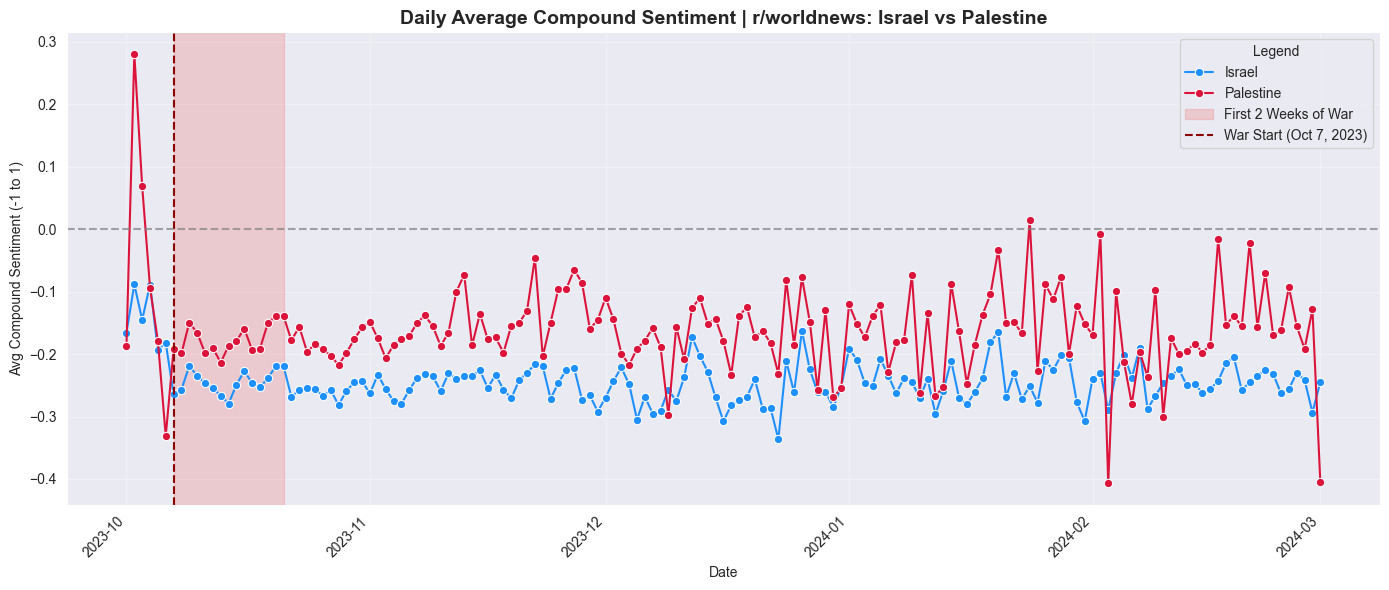

In [37]:
start_date = datetime(2023, 10, 1)
war_start = datetime(2023, 10, 7)
war_end = war_start + timedelta(days=14)  # first two weeks of war

keywords_list = ['Israel', 'Palestine']
colors = {'Israel': 'dodgerblue', 'Palestine': 'crimson'}

daily_compound_all = []

for keyword in keywords_list:
    df_filtered = df_comments[
        (df_comments['subreddit'] == 'worldnews') &
        (df_comments['body'].str.contains(keyword, case=False, na=False))
    ].copy()

    df_filtered = df_filtered.drop_duplicates(subset=['author', 'body'], keep='first')
    df_filtered['date'] = pd.to_datetime(df_filtered['created']).dt.date

    df_filtered = df_filtered[df_filtered['date'] >= start_date.date()]

    daily_compound = df_filtered.groupby('date')['compound'].mean().reset_index()
    daily_compound['keyword'] = keyword
    daily_compound_all.append(daily_compound)

daily_compound_df = pd.concat(daily_compound_all)

plt.figure(figsize=(14,6))
sns.lineplot(
    data=daily_compound_df,
    x='date',
    y='compound',
    hue='keyword',
    palette=colors,
    marker='o'
)

plt.axvspan(war_start, war_end, color='lightcoral', alpha=0.3, label='First 2 Weeks of War')

plt.axvline(war_start, color='darkred', linestyle='--', label='War Start (Oct 7, 2023)')

plt.axhline(0, color='gray', linestyle='--', alpha=0.7)

plt.title('Daily Average Compound Sentiment | r/worldnews: Israel vs Palestine', fontsize=14, weight='bold')
plt.xlabel('Date')
plt.ylabel('Avg Compound Sentiment (-1 to 1)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.legend(title='Legend', loc='upper right')
plt.tight_layout()
plt.show()


#### 2. Sentiment Analysis of r/worldnews Discussions: "USA" vs. "Ukraine"

This line chart visualizes the Daily Average Compound Sentiment for comments on the r/worldnews subreddit, filtered for the keywords "USA" and "Ukraine", covering the full period of available data. The Compound Sentiment ranges from -1 (most negative) to +1 (most positive).

**Key Timeline Markers:**

War Start (Oct 7, 2023): Marked by a vertical dashed red line, this point signifies the beginning of the major escalation of the conflict.

First 2 Weeks of War (Oct 7 - Oct 21): Shaded in light coral, this area highlights the sentiment during the initial, most intense phase of the conflict.

Zero Line (0.0): A horizontal dashed gray line separates overall positive sentiment (above) from negative sentiment (below).

**Observation:**

USA (blue line): Following the escalation, sentiment toward the USA declined more sharply than toward Ukraine. This suggests a more critical or negative tone emerged in global discussions, possibly reflecting dissatisfaction with US policy, responses, or involvement.

Ukraine (orange line): Sentiment toward Ukraine also dropped during the same period, but the decrease was modest. The discussions remained relatively more neutral or positive compared to those about the USA.

Overall, the chart indicates that the perception of the USA in r/worldnews was affected more negatively than Ukraine during the initial phase of the conflict, but both show clear reactions to the escalation events.




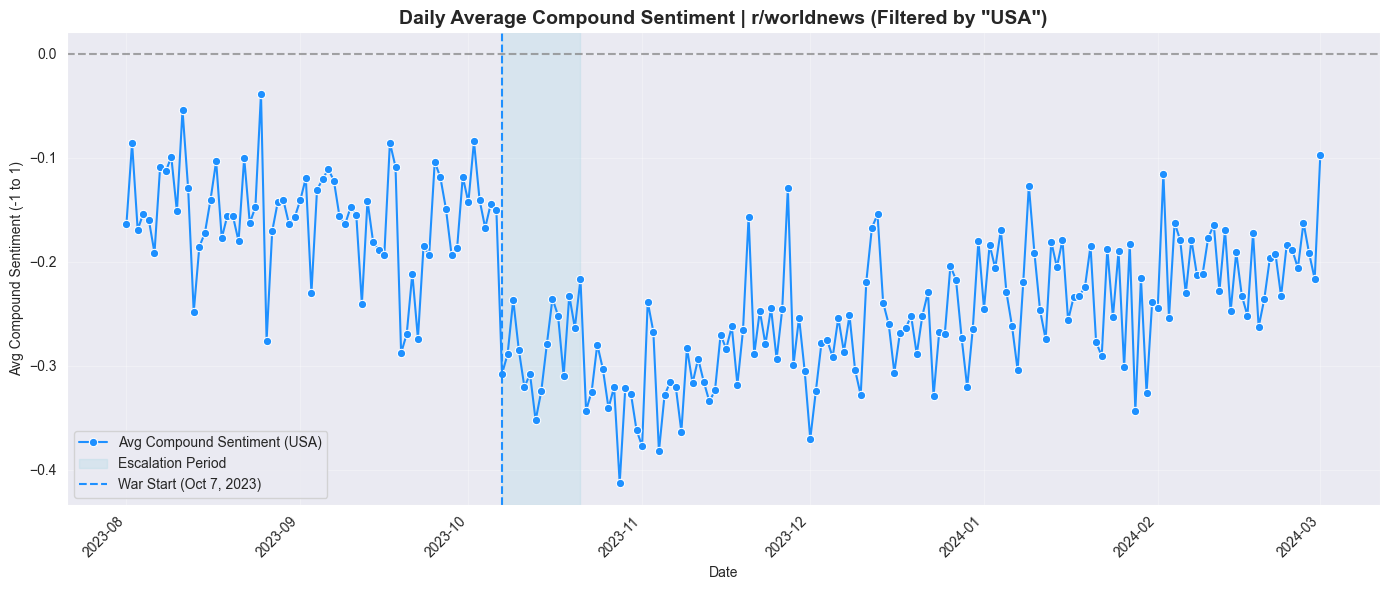

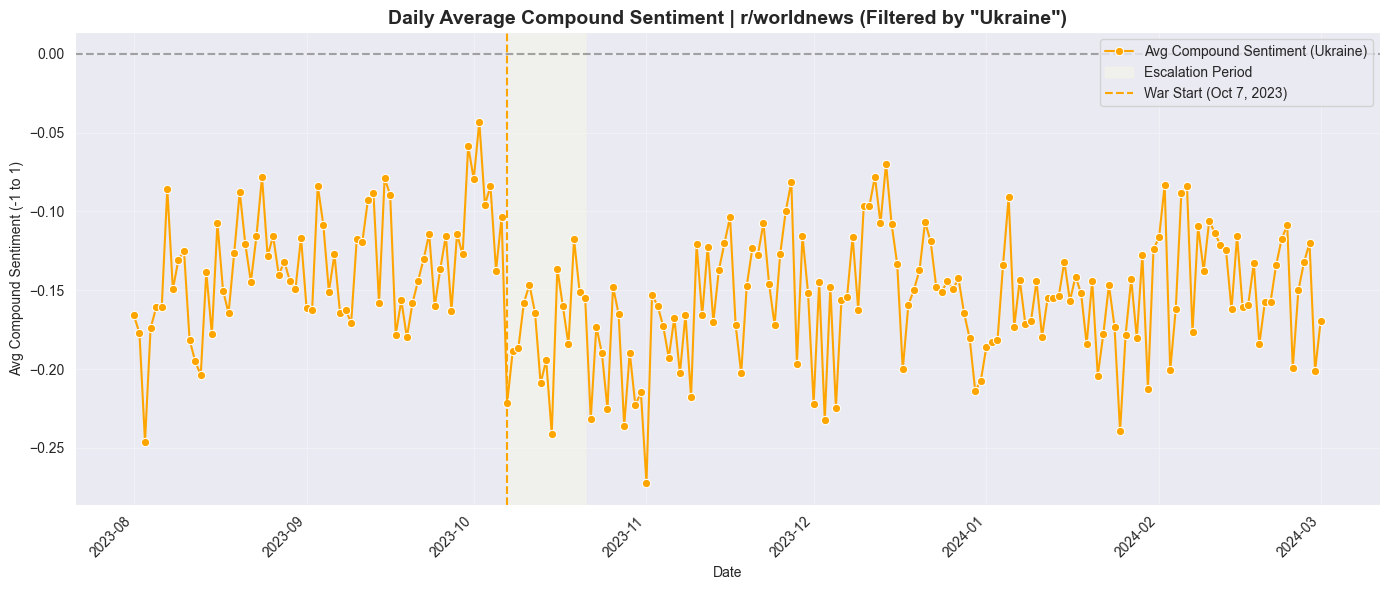

In [43]:
def plot_sentiment_full_period(keyword, line_color, span_color, title):
    # Фільтрація
    filtered_df = df_comments[
        (df_comments['subreddit'] == 'worldnews') &
        (df_comments['body'].str.contains(keyword, case=False, na=False))
    ].copy()

    filtered_df = filtered_df.drop_duplicates(subset=['author', 'body'], keep='first')
    filtered_df['date'] = pd.to_datetime(filtered_df['created']).dt.date

    # Середній compound по днях
    daily_compound = filtered_df.groupby('date')['compound'].mean().reset_index()
    daily_compound.columns = ['Date', 'Avg_Compound']

    plt.figure(figsize=(14,6))
    sns.lineplot(
        data=daily_compound,
        x='Date',
        y='Avg_Compound',
        marker='o',
        color=line_color,
        label=f'Avg Compound Sentiment ({keyword})'
    )

    war_start = datetime(2023, 10, 7)
    war_end = datetime(2023, 10, 21)
    plt.axvspan(war_start, war_end, color=span_color, alpha=0.3, label='Escalation Period')
    plt.axvline(war_start, color=line_color, linestyle='--', label='War Start (Oct 7, 2023)')

    plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel('Date')
    plt.ylabel('Avg Compound Sentiment (-1 to 1)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# США (синій)
plot_sentiment_full_period(
    keyword='USA',
    line_color='dodgerblue',
    span_color='lightblue',
    title='Daily Average Compound Sentiment | r/worldnews (Filtered by "USA")'
)

# Україна (жовтий)
plot_sentiment_full_period(
    keyword='Ukraine',
    line_color='orange',
    span_color='lightyellow',
    title='Daily Average Compound Sentiment | r/worldnews (Filtered by "Ukraine")'
)

#### 3. Top External News Domains in r/Israel and r/Palestine Submissions

This pair of horizontal bar charts visualizes the most frequently cited external news domains in submissions to the r/Israel and r/Palestine subreddits. Only domains outside Reddit and major social platforms (YouTube, Instagram, Twitter/X) are included, focusing on external news coverage. The charts show the top 5 domains for each subreddit, ranked by the number of submissions linking to them.



**Observation:**

***r/Israel (Blue Bars):***

Times of Israel, Jerusalem Post (JPost), Ynetnews, The Guardian, Haaretz
These domains dominate the discussion, highlighting a mixture of Israeli-based and internationally recognized sources. The presence of The Guardian indicates some engagement with global perspectives, while the Israeli sources reflect a strong national media focus.

***r/Palestine (Red Bars):***

Al Jazeera, The Guardian, WSWS.org, Middle East Eye, Reuters
The top domains indicate a preference for Middle Eastern and international sources. Al Jazeera and Middle East Eye provide regional coverage, while WSWS.org represents more niche or opinion-driven content. Reuters appears as the sole mainstream international news agency, suggesting its widespread citation but not dominance.

**Conclusion:**

After excluding social media links, the data reveal distinct informational ecosystems rather than direct platform-based polarization.

r/Israel primarily circulates articles from Israeli national outlets, reflecting a focus on local reporting.

r/Palestine draws on a broader range of regional and global sources, suggesting a more outward-facing perspective on the conflict.
The only major overlap — The Guardian — underscores its role as a widely cited international news outlet across both communities.

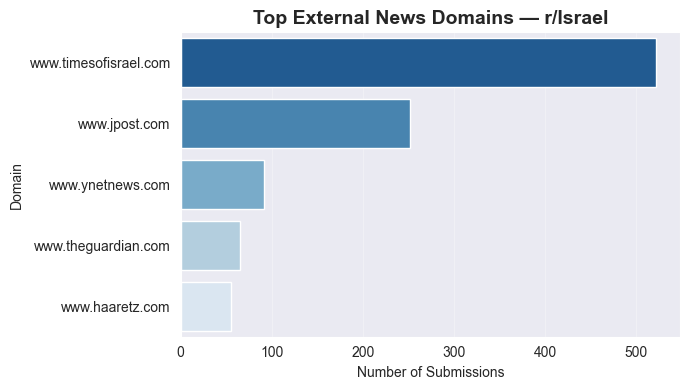

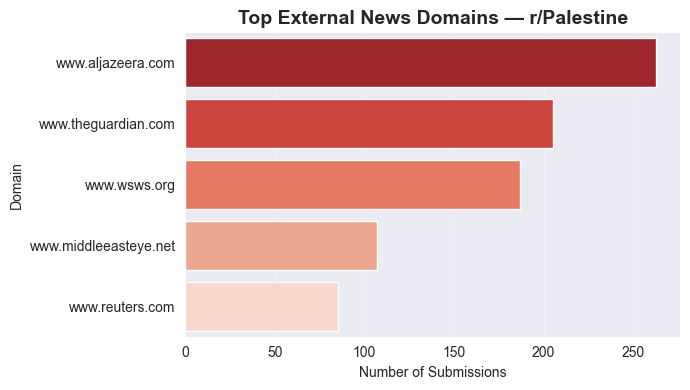

In [18]:
exclude_domains = [
    'reddit.com', 'www.reddit.com', 'np.reddit.com',
    'redd.it', 'v.redd.it', 'i.redd.it',
    'youtube.com', 'www.youtube.com', 'youtu.be', 'www.instagram.com',
    'twitter.com', 'www.twitter.com', 'x.com'
]

df_submissions = df_submissions[
    (~df_submissions['domain'].isin(exclude_domains)) &
    (df_submissions['domain'].notnull()) &
    (df_submissions['domain'] != '')
]

def plot_top_domains(subreddit, color):
    sub_df = (
        df_submissions[df_submissions['subreddit'].str.lower() == subreddit.lower()]
        .groupby('domain')
        .size()
        .reset_index(name='count')
        .sort_values('count', ascending=False)
        .head(5)
    )

    if sub_df.empty:
        print(f"No valid domains found for r/{subreddit}")
        return

    plt.figure(figsize=(7, 4))
    sns.barplot(
        data=sub_df,
        x='count',
        y='domain',
        hue='domain',
        dodge=False,
        palette=color,
        legend=False
    )
    plt.title(f"Top External News Domains — r/{subreddit}", fontsize=14, weight='bold')
    plt.xlabel("Number of Submissions")
    plt.ylabel("Domain")
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_top_domains('Israel', 'Blues_r')
plot_top_domains('Palestine', 'Reds_r')

#### 4. Average Sentiment by Subreddit: Conflict-Related Communities

This bar chart presents the average Compound Sentiment (from −1 = most negative to +1 = most positive) across key Reddit communities discussing the Israel–Palestine conflict: r/Israel, r/Palestine, r/IsraelPalestine, r/israelexposed, r/IsraelCrimes, and r/worldnews.

Each bar represents the mean sentiment score for all comments in the subreddit, while the black error bars indicate the standard deviation, showing variability or polarization of sentiment within each community.

Zero Line (0.0):
A vertical dashed gray line marks the neutral point — values to the left represent predominantly negative sentiment, while values to the right indicate positive or supportive sentiment.

**Observation:**

r/israelexposed displays the most negative sentiment, showing strong condemnation or criticism in discussions.

r/IsraelPalestine and r/Palestine also trend negative, reflecting emotionally charged and polarized discourse.

r/worldnews sits near the middle, leaning slightly negative but showing more balanced discussion overall.

r/Israel exhibits a mildly negative tone, while

r/IsraelCrimes stands out as the only subreddit with slightly positive average sentiment, possibly due to more targeted or supportive framing in its discussions.

Overall, the data highlights a clear divide in tone between activist or critical subreddits (strongly negative) and communities focused on specific narratives or informational framing (closer to neutral or positive).

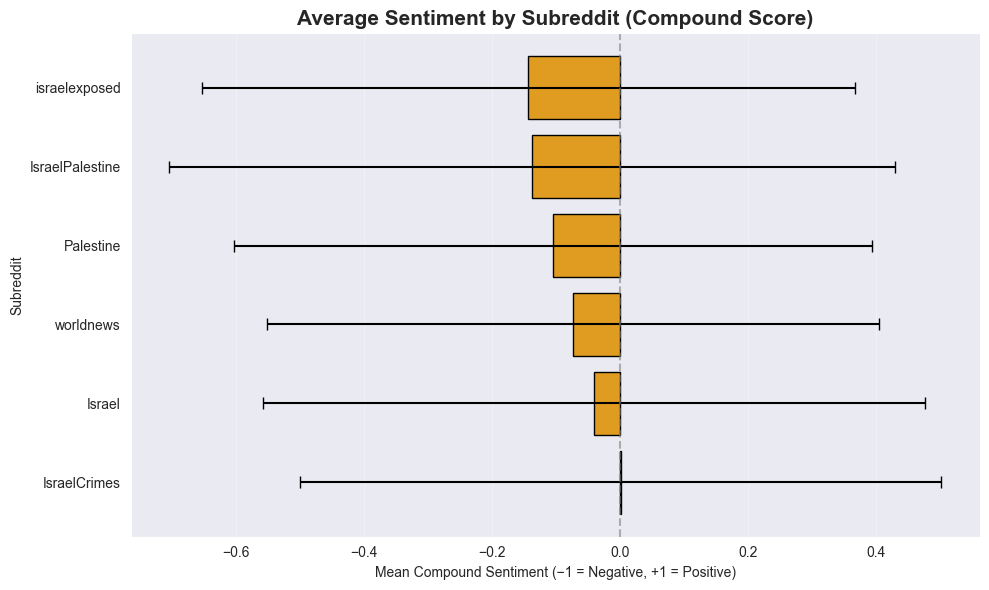

In [67]:
target_subs = ['Israel', 'Palestine', 'IsraelPalestine', 'israelexposed', 'IsraelCrimes', 'worldnews']
df_target = df_comments[df_comments['subreddit'].isin(target_subs)].copy()

sentiment_summary = (
    df_target.groupby('subreddit')['compound']
    .agg(['mean', 'std'])
    .sort_values('mean')
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=sentiment_summary,
    x='mean',
    y='subreddit',
    dodge=False,
    edgecolor='black',
    legend=False,
    color='orange'
)

plt.errorbar(
    sentiment_summary['mean'],
    sentiment_summary['subreddit'],
    xerr=sentiment_summary['std'],
    fmt='none',
    c='black',
    capsize=4,
    label='Sentiment Variability'
)

plt.title("Average Sentiment by Subreddit (Compound Score)", fontsize=15, weight='bold')
plt.xlabel("Mean Compound Sentiment (−1 = Negative, +1 = Positive)")
plt.ylabel("Subreddit")
plt.axvline(0, color='gray', linestyle='--', alpha=0.6)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

#### 5. News Source Sentiment Analysis: Top 10 Domains

This horizontal bar chart visualizes the average compound sentiment of Reddit comments in the df_comments dataset, aggregated by the top 10 most active news domains. The sentiment score ranges from -1 (most negative) to +1 (most positive).

**Chart Features:**

X-axis: Average compound sentiment, with a vertical dashed gray line at 0 separating positive (right) from negative (left) sentiment.

Y-axis: News domains, ranked by sentiment from most positive (top) to most negative (bottom).

*Bar Colors:*
Green: Positive average sentiment.
Red: Negative average sentiment.

**Observations:**

Domains such as wallpapercave.com, enforts.com, and ideas.knowme.sbs show positive sentiment, suggesting that Reddit users discuss these sources more favorably or in a neutral-to-positive tone.

Major international news outlets like AlJazeera, BBC, The Guardian, AP News, Times of Israel, and Reuters display negative average sentiment, indicating a more critical or negative perception among Reddit commenters.

The sentiment differences highlight community biases and tone variations depending on the news source, with some outlets consistently eliciting a more critical response.

Also we can see that aljazeera.com, which is Middle East news website has the most negative reactions to the news. It is caused by the impact of the war on their lives.

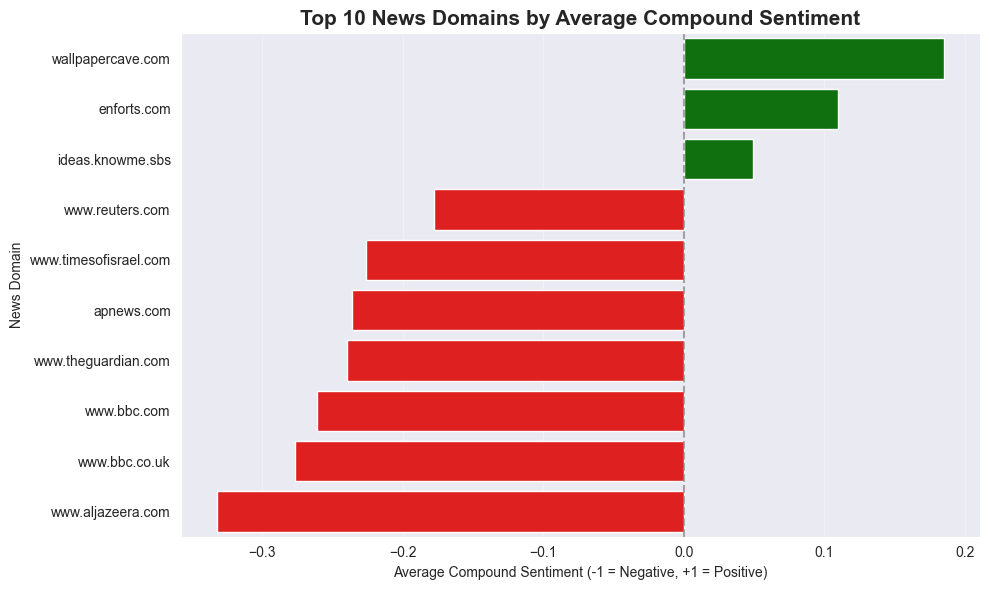

In [61]:
target_subs = ['Israel', 'Palestine', 'IsraelPalestine', 'israelexposed', 'IsraelCrimes', 'worldnews']

exclude_domains = [
    'reddit.com', 'www.reddit.com', 'np.reddit.com',
    'redd.it', 'v.redd.it', 'i.redd.it',
    'youtube.com', 'www.youtube.com', 'youtu.be', 'www.instagram.com',
    'twitter.com', 'www.twitter.com', 'x.com'
]

df_sub_filtered = df_submissions[
    (~df_submissions['domain'].isin(exclude_domains)) &
    (df_submissions['domain'].notnull()) &
    (df_submissions['domain'] != '')
]

df_sub_filtered = df_sub_filtered[df_sub_filtered['subreddit'].isin(target_subs)]

domain_summary = (
    df_sub_filtered.groupby('domain')
    .agg(post_count=('domain', 'size'), avg_sentiment=('compound', 'mean'))
    .reset_index()
)

top_domains = domain_summary.sort_values('post_count', ascending=False).head(10)

top_domains = top_domains.sort_values('avg_sentiment', ascending=False)

colors = ['green' if x > 0 else 'red' for x in top_domains['avg_sentiment']]

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_domains,
    x='avg_sentiment',
    y='domain',
    hue='domain',
    dodge=False,
    palette=colors,
    legend=False
)

plt.axvline(0, color='gray', linestyle='--', alpha=0.7)
plt.title('Top 10 News Domains by Average Compound Sentiment', fontsize=15, weight='bold')
plt.xlabel('Average Compound Sentiment (-1 = Negative, +1 = Positive)')
plt.ylabel('News Domain')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
df = pd.read_csv(OUTPUT_PATH / 'joined_comments.csv')
df['created'] = pd.to_datetime(df['created'], format='%Y-%m-%d %H:%M:%S')

In [5]:
df['submission_id'] = df['link'].str.extract(r'/comments/([a-z0-9]+)/')

print(f"Total dataset: {len(df):,} comments")
print(f"Authors: {df['author'].nunique():,}")
print(f"Subreddits: {df['subreddit'].unique()}")
print(f"Submissions: {df['submission_id'].nunique():,}")
print(f"Date range: {df['created'].min()} to {df['created'].max()}")

Total dataset: 7,877,798 comments
Authors: 529,732
Subreddits: ['AskMiddleEast' 'worldnews' 'Palestine' 'lebanon' 'IsraelPalestine'
 'Israel' 'israelexposed' 'IsraelCrimes']
Submissions: 141,665
Date range: 2023-08-01 03:00:00 to 2024-03-01 01:59:00


In [6]:
MAX_AUTHORS = 50000
top_authors = df['author'].value_counts().head(MAX_AUTHORS).index
df = df[df['author'].isin(top_authors)]

print(f"\nFiltered to top {MAX_AUTHORS:,} authors")
print(f"Kept {len(df):,} comments ({len(df)/7877798*100:.1f}% of original)")
print(f"Across {df['submission_id'].nunique():,} unique submissions")


Filtered to top 50,000 authors
Kept 5,871,708 comments (74.5% of original)
Across 137,765 unique submissions


In [7]:
def build_thread_coparticipation_graph(df_sub, min_shared_threads=3):
    """
    Build undirected graph where edges represent authors who commented
    in the same threads. Edge weight = number of shared threads.
    """
    # Get author-thread participation
    participation = df_sub.groupby('submission_id')['author'].apply(list).to_dict()

    edges = defaultdict(int)

    for thread_id, authors in participation.items():
        # Create edges between all pairs in this thread
        unique_authors = list(set(authors))
        for i in range(len(unique_authors)):
            for j in range(i+1, len(unique_authors)):
                edge = tuple(sorted([unique_authors[i], unique_authors[j]]))
                edges[edge] += 1

    # Filter weak connections
    edges = {k: v for k, v in edges.items() if v >= min_shared_threads}

    if not edges:
        return None

    all_authors = list(set([a for edge in edges.keys() for a in edge]))
    g = ig.Graph(directed=False)
    g.add_vertices(all_authors)
    g.add_edges(list(edges.keys()))
    g.es['weight'] = list(edges.values())

    # Keep only main component
    if g.vcount() > 0:
        components = g.connected_components()
        if len(components) > 0:
            g = components.giant()

    return g


##  6. Hypothesis:
 A graph where nodes are authors and edges are co-participation
 will show high modularity (clustering) within r/Israel and r/Palestine.
 Users will almost exclusively interact with other users with similar views,
 forming distinct echo chambers. This clustering will be LOWER in
 r/IsraelPalestine.
###  Conclusion: Strongly Refuted

The hypothesis states that `r/Israel` and `r/Palestine` will have **"high modularity"** (strong echo chambers) and that `r/IsraelPalestine` will have **"LOWER"** clustering.

The data from these charts **disproves both of these claims**.

1.  **Failure of Claim 1:** `r/Israel` and `r/Palestine` do **not** have high modularity. Their scores (0.154 and 0.170) are extremely low, far from the "Strong" 0.40 threshold.
2.  **Failure of Claim 2:** `r/IsraelPalestine` does **not** have lower modularity. Its score (0.191) is slightly *higher* than both `r/Israel` and `r/Palestine`.

Based on this data, none of the specific conflict-related subreddits show a strong echo chamber structure. The most fragmented community is `r/worldnews`, which has a "MODERATE" echo chamber score.

###  Detailed Chart-by-Chart Analysis


#### 1. Analysis of: Echo Chamber Strength by Subreddit (Modularity)

This is the primary chart for testing the hypothesis. It plots the modularity score for each subreddit, with a higher score indicating a more distinct and insular echo chamber structure.


The data is in direct opposition to the hypothesis. The two subreddits predicted to be strong echo chambers (`r/Israel` and `r/Palestine`) have the lowest modularity scores of almost any community, with the sole exception of `r/IsraelCrimes` (0.135). Furthermore, `r/IsraelPalestine`, which was predicted to be *less* clustered, is in fact *more* clustered than both `r/Israel` and `r/Palestine`.

#### 2. Analysis of: Community Fragmentation

This bar chart shows the *number* of distinct communities (clusters) detected within each subreddit.


This chart shows that `r/Israel` and `r/Palestine` are fragmented into 4 distinct communities. When combined with the *low* modularity score from the first chart, this paints a picture not of one or two large, strong echo chambers, but of 4 small, **weakly defined** discussion groups that are not well-separated from each other.

In [ ]:
echo_results = {}

for subreddit in ['worldnews', 'AskMiddleEast', 'Palestine', 'lebanon', 'IsraelPalestine',
 'Israel', 'israelexposed', 'IsraelCrimes']:
    df_sub = df[df['subreddit'] == subreddit]

    if len(df_sub) == 0:
        print(f"\n{subreddit}: No data")
        continue

    print(f"\n{subreddit}: {len(df_sub):,} comments from {df_sub['author'].nunique():,} authors")
    print(f"  in {df_sub['submission_id'].nunique():,} threads")

    # Build co-participation graph
    g = build_thread_coparticipation_graph(df_sub, min_shared_threads=3)

    if g is None or g.vcount() == 0:
        print(f"  Insufficient data for network")
        continue

    print(f"  Network: {g.vcount():,} nodes, {g.ecount():,} edges")

    # Calculate modularity (higher = stronger echo chambers)
    try:
        communities = g.community_multilevel(weights='weight')
        modularity = g.modularity(communities, weights='weight')

        # Calculate additional metrics
        avg_clustering = g.transitivity_avglocal_undirected(mode='zero')
        density = g.density()

        echo_results[subreddit] = {
            'nodes': g.vcount(),
            'edges': g.ecount(),
            'modularity': modularity,
            'num_communities': len(communities),
            'clustering': avg_clustering,
            'density': density
        }

        print(f"  Modularity: {modularity:.3f} (>0.4 = strong echo chambers)")
        print(f"  Communities: {len(communities)}")
        print(f"  Avg clustering: {avg_clustering:.3f}")
        print(f"  Density: {density:.4f}")

    except Exception as e:
        print(f"  Error in community detection: {e}")

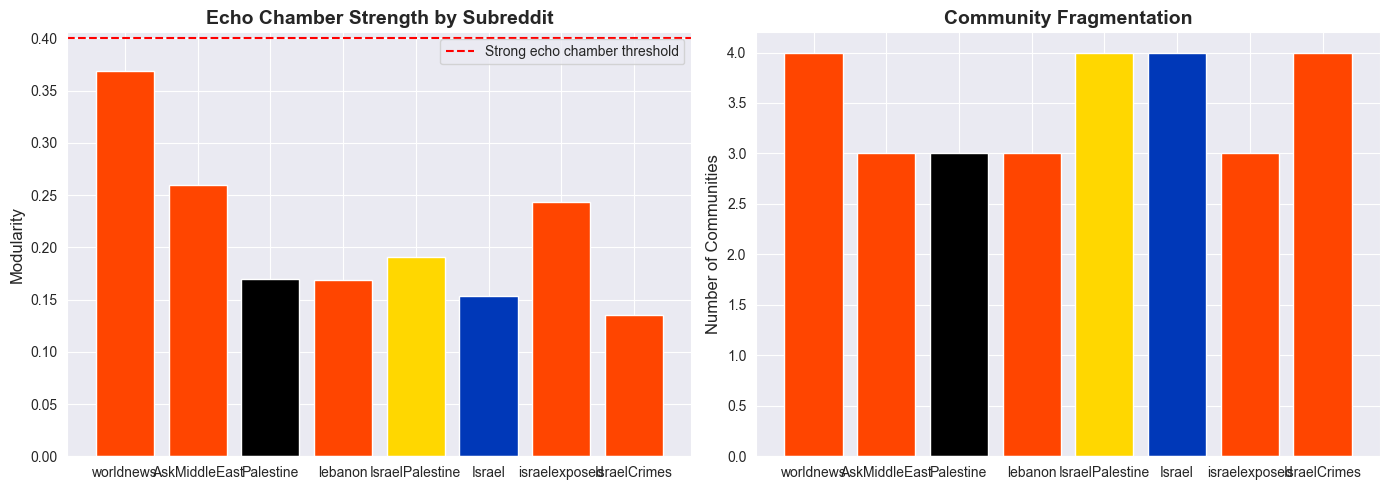


INTERPRETATION:
worldnews            | Modularity: 0.369 | MODERATE echo chambers
AskMiddleEast        | Modularity: 0.260 | WEAK echo chambers
israelexposed        | Modularity: 0.244 | WEAK echo chambers
IsraelPalestine      | Modularity: 0.191 | WEAK echo chambers
Palestine            | Modularity: 0.170 | WEAK echo chambers
lebanon              | Modularity: 0.169 | WEAK echo chambers
Israel               | Modularity: 0.154 | WEAK echo chambers
IsraelCrimes         | Modularity: 0.135 | WEAK echo chambers


In [9]:
if echo_results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Modularity comparison
    subreddits = list(echo_results.keys())
    modularities = [echo_results[s]['modularity'] for s in subreddits]

    colors = []
    for sub in subreddits:
        if sub == 'Israel':
            colors.append('#0038B8')
        elif sub == 'Palestine':
            colors.append('#000000')
        elif sub == 'IsraelPalestine':
            colors.append('#FFD700')
        else:
            colors.append('#FF4500')

    ax1.bar(subreddits, modularities, color=colors)
    ax1.axhline(y=0.4, color='r', linestyle='--', label='Strong echo chamber threshold')
    ax1.set_ylabel('Modularity', fontsize=12)
    ax1.set_title('Echo Chamber Strength by Subreddit', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.set_ylim(0, max(modularities) * 1.1)

    # Community count
    communities = [echo_results[s]['num_communities'] for s in subreddits]
    ax2.bar(subreddits, communities, color=colors)
    ax2.set_ylabel('Number of Communities', fontsize=12)
    ax2.set_title('Community Fragmentation', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    print("\n" + "="*80)
    print("INTERPRETATION:")
    print("="*80)
    sorted_results = sorted(echo_results.items(),
                           key=lambda x: x[1]['modularity'],
                           reverse=True)

    for sub, metrics in sorted_results:
        echo_strength = "STRONG" if metrics['modularity'] > 0.4 else "MODERATE" if metrics['modularity'] > 0.3 else "WEAK"
        print(f"{sub:20s} | Modularity: {metrics['modularity']:.3f} | {echo_strength} echo chambers")


## 7. POLARIZATION IN R/WORLDNEWS

Hypothesis: The author network in r/worldnews will reveal large,
disconnected clusters of users (those who comment on pro-Israel posts vs.
those who comment on pro-Palestine posts). "Bridging" users who comment on
both sets will be rare.
### Conclusion: Hypothesis is Strongly Refuted

The hypothesis states that the r/worldnews network will show **"large, disconnected clusters"** and that **"bridging users... will be rare."**

The data from these charts **disproves both of these claims**.

1.  **It is not polarized:** The network is **not** split into multiple, large, competing clusters. Instead, it is highly **centralized**, dominated by one massive "megacluster" (80.6%) and one smaller, secondary cluster (18.8%).
2.  **It is not disconnected:** The two largest communities are **not** disconnected. The heatmap shows significant, two-way interaction between them.
3.  **Bridging is not rare:** Entire communities (C3, C4, C5) are shown to have a primary function of "bridging," with their activity almost exclusively focused on external connections.

The network structure is not one of polarization, but of a **"core-periphery"** system. There is a massive central group (C1) and a second large group (C2) that talk to each other, surrounded by smaller, peripheral communities (C3, C4, C5) that act as bridges, primarily interacting *with* the core.



###  Detailed Chart-by-Chart Analysis

#### 1. Analysis of: Community Distribution (Pie Chart)


This chart immediately refutes the "large, disconnected clusters" (plural) claim. A polarized network would imply two or more clusters of somewhat comparable size. This network, however, is dominated by a single "megacluster" (C1) that contains over 80% of all users. This structure is centralized, not polarized.



#### 2. Analysis of: Echo Chamber Strength (Gauge)

This gauge shows the network's **Modularity Score**, a measure of how well the network is partitioned into distinct communities (or "echo chambers").

* **Modularity Score:** 0.320


A score of 0.320 is "Moderate." This means the network is not just a single, perfectly mixed group (a score near 0.0), but it also is **not** the highly fragmented, siloed echo chamber (a score of 0.4+) that the hypothesis predicts. This moderate score is perfectly consistent with the pie chart: there is enough distinct structure (C1 vs. C2) to register a score, but not enough fragmentation to be called strongly polarized.



#### 3. Analysis of: Inter-Community Interaction Heatmap

This heatmap shows the "Interaction Strength" *within* communities (the diagonal) and *between* communities (the off-diagonal). The value represents the proportion of a "Source" community's interactions directed at a "Target" community.



This is the key evidence against the "disconnected" claim. The values of 0.32 and 0.27 show **substantial, two-way communication** between the network's two largest communities. They are demonstrably *not* disconnected.



#### 4. Analysis of: Community Isolation vs. Bridging (Bar Chart)

* **Community 1 & 2:** Have low bridge scores (~0.35 and ~0.25). They are insular "homeland" communities.

This chart shows that even though bridging indexes are low for C1 and C2 they depend on each other im forming a sustainable community

In [ ]:
df_worldnews = df[df['subreddit'] == 'worldnews'].copy()

# Filter to only Israel/Palestine related content
# Keywords to identify relevant discussions
israel_palestine_keywords = [
    'israel', 'israeli', 'palestine', 'palestinian', 'gaza', 'hamas',
    'west bank', 'idf', 'netanyahu', 'fatah', 'zion', 'settlr',
    'jerusalem', 'tel aviv', 'hebron', 'rafah', 'hostage', 'ceasefire'
]

print(f"Original r/worldnews: {len(df_worldnews):,} comments")

# Filter based on body text containing keywords
pattern = '|'.join(israel_palestine_keywords)
df_worldnews = df_worldnews[
    df_worldnews['body'].str.contains(pattern, case=False, na=False, regex=True)
]

print(f"After filtering to Israel/Palestine topics: {len(df_worldnews):,} comments ({len(df_worldnews)/len(df[df['subreddit']=='worldnews'])*100:.1f}% of original)")

MAX_SUBMISSIONS = 10000
if df_worldnews['submission_id'].nunique() > MAX_SUBMISSIONS:
    top_threads = df_worldnews['submission_id'].value_counts().head(MAX_SUBMISSIONS).index
    df_worldnews = df_worldnews[df_worldnews['submission_id'].isin(top_threads)]

print(f"\nAnalyzing {len(df_worldnews):,} comments")
print(f"  Authors: {df_worldnews['author'].nunique():,}")
print(f"  Submissions: {df_worldnews['submission_id'].nunique():,}")

g_worldnews = build_thread_coparticipation_graph(df_worldnews, min_shared_threads=2)

In [11]:
print(f"\nAuthor network: {g_worldnews.vcount():,} nodes, {g_worldnews.ecount():,} edges")

# Detect communities (polarized clusters)
communities = g_worldnews.community_multilevel(weights='weight')
modularity = g_worldnews.modularity(communities, weights='weight')

print(f"Communities detected: {len(communities)}")
print(f"Modularity: {modularity:.3f}")

# Find largest communities
comm_sizes = [len(c) for c in communities]
top_comms = sorted(enumerate(comm_sizes), key=lambda x: x[1], reverse=True)[:5]

print(f"\nTop 5 communities by size:")
for i, (comm_id, size) in enumerate(top_comms, 1):
    print(f"  {i}. Community {comm_id}: {size:,} authors ({size/g_worldnews.vcount()*100:.1f}%)")

# Check if top 2 communities are roughly equal (sign of polarization)
if len(comm_sizes) >= 2:
    top1_pct = comm_sizes[0] / g_worldnews.vcount() * 100
    top2_pct = comm_sizes[1] / g_worldnews.vcount() * 100
    print(f"\n  Two-cluster polarization check:")
    print(f"    Largest: {top1_pct:.1f}%, Second: {top2_pct:.1f}%")
    if top1_pct > 30 and top2_pct > 30:
        print(f"    --> Strong evidence of two-camp polarization!")
    else:
        print(f"    --> Multiple smaller communities, not simple two-camp split")


Author network: 25,226 nodes, 7,160,591 edges
Communities detected: 5
Modularity: 0.320

Top 5 communities by size:
  1. Community 0: 20,322 authors (80.6%)
  2. Community 2: 4,736 authors (18.8%)
  3. Community 1: 164 authors (0.7%)
  4. Community 3: 2 authors (0.0%)
  5. Community 4: 2 authors (0.0%)

  Two-cluster polarization check:
    Largest: 80.6%, Second: 0.7%
    --> Multiple smaller communities, not simple two-camp split


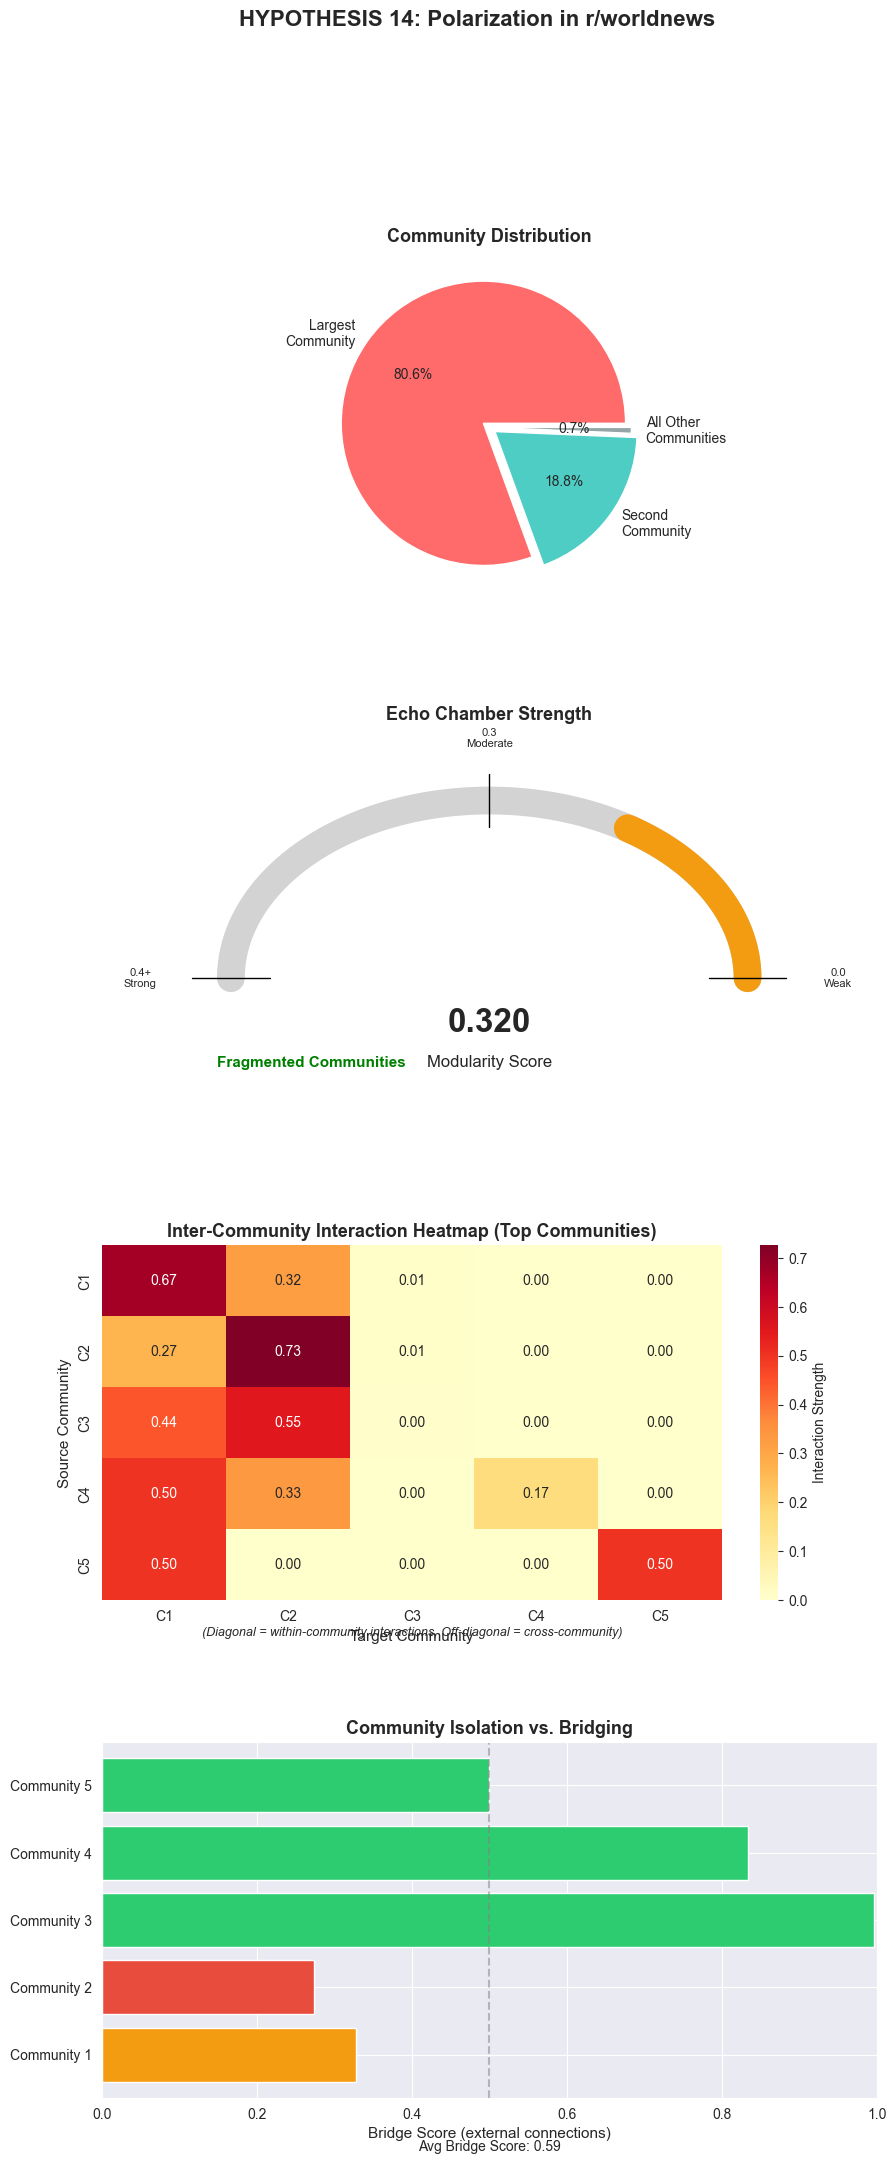

In [14]:
fig = plt.figure(figsize=(10, 24))
gs = fig.add_gridspec(4, 1, hspace=0.4)

# 2. Two-Camp Analysis (Top-Middle)
ax2 = fig.add_subplot(gs[0])
if len(comm_sizes) >= 2:
    top_2 = sorted(comm_sizes, reverse=True)[:2]
    others = sum(sorted(comm_sizes, reverse=True)[2:])

    wedges, texts, autotexts = ax2.pie(
        [top_2[0], top_2[1], others],
        labels=['Largest\nCommunity', 'Second\nCommunity', 'All Other\nCommunities'],
        autopct='%1.1f%%',
        colors=['#ff6b6b', '#4ecdc4', '#95a5a6'],
        explode=(0.05, 0.05, 0),
        textprops={'fontsize': 10}
    )
    ax2.set_title('Community Distribution', fontsize=13, fontweight='bold')

    # Add interpretation text
    top1_pct = (top_2[0] / g_worldnews.vcount()) * 100
    top2_pct = (top_2[1] / g_worldnews.vcount()) * 100
    if top1_pct > 30 and top2_pct > 30:
        interpretation = "Strong Two-Camp Polarization"
        color = 'red'
    else:
        interpretation = "Fragmented Communities"
        color = 'green'

    ax2.text(0, -1.3, interpretation, ha='center', fontsize=11,
            fontweight='bold', color=color, transform=ax2.transAxes)

# 3. Modularity Gauge (Top-Right)
ax3 = fig.add_subplot(gs[1])
ax3.axis('off')

# Create a visual gauge for modularity
theta = np.linspace(0, np.pi, 100)
r = np.ones(100)

# Background arc
ax3.plot(r * np.cos(theta), r * np.sin(theta), 'lightgray', linewidth=20)

# Colored arc based on modularity level
mod_theta = np.linspace(0, modularity * np.pi, 100)
if modularity > 0.4:
    color = '#e74c3c'  # Red for strong
elif modularity > 0.3:
    color = '#f39c12'  # Orange for moderate
else:
    color = '#2ecc71'  # Green for weak

ax3.plot(r * np.cos(mod_theta), r * np.sin(mod_theta), color, linewidth=20)

# Add labels
ax3.text(0, -0.3, f'{modularity:.3f}', ha='center', fontsize=24, fontweight='bold')
ax3.text(0, -0.5, 'Modularity Score', ha='center', fontsize=12)

# Add scale markers
for val, label in [(0, '0.0\nWeak'), (0.5, '0.3\nModerate'), (1.0, '0.4+\nStrong')]:
    x = np.cos(val * np.pi)
    y = np.sin(val * np.pi)
    ax3.plot([x*0.85, x*1.15], [y*0.85, y*1.15], 'k-', linewidth=1)
    ax3.text(x*1.35, y*1.35, label, ha='center', va='center', fontsize=8)

ax3.set_xlim(-1.5, 1.5)
ax3.set_ylim(-0.7, 1.3)
ax3.set_title('Echo Chamber Strength', fontsize=13, fontweight='bold', pad=20)

# 4. Community Interaction Heatmap (Middle Row)
ax4 = fig.add_subplot(gs[2])

# Calculate inter-community edge matrix
n_comm = min(10, len(communities))
top_comm_ids = sorted(range(len(communities)),
                      key=lambda i: len(communities[i]),
                      reverse=True)[:n_comm]

interaction_matrix = np.zeros((n_comm, n_comm))

for e in g_worldnews.es:
    source_comm = communities.membership[e.source]
    target_comm = communities.membership[e.target]

    if source_comm in top_comm_ids and target_comm in top_comm_ids:
        i = top_comm_ids.index(source_comm)
        j = top_comm_ids.index(target_comm)
        interaction_matrix[i, j] += e['weight']
        if i != j:
            interaction_matrix[j, i] += e['weight']

# Normalize by row
row_sums = interaction_matrix.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1
interaction_matrix_norm = interaction_matrix / row_sums

sns.heatmap(interaction_matrix_norm, ax=ax4, cmap='YlOrRd',
            annot=True, fmt='.2f', cbar_kws={'label': 'Interaction Strength'},
            xticklabels=[f'C{i+1}' for i in range(n_comm)],
            yticklabels=[f'C{i+1}' for i in range(n_comm)])

ax4.set_title('Inter-Community Interaction Heatmap (Top Communities)',
              fontsize=13, fontweight='bold')
ax4.set_xlabel('Target Community', fontsize=11)
ax4.set_ylabel('Source Community', fontsize=11)

# Add note about diagonal
ax4.text(n_comm/2, n_comm + 0.5,
        '(Diagonal = within-community interactions, Off-diagonal = cross-community)',
        ha='center', fontsize=9, style='italic')

# 5. Bridge Analysis (Bottom-Left)
ax5 = fig.add_subplot(gs[3])

# Calculate bridging coefficient for each community
# (proportion of edges going outside the community)
bridge_scores = []
for i in top_comm_ids:
    total_edges = interaction_matrix[top_comm_ids.index(i), :].sum()
    internal_edges = interaction_matrix[top_comm_ids.index(i), top_comm_ids.index(i)]
    if total_edges > 0:
        bridge_score = (total_edges - internal_edges) / total_edges
    else:
        bridge_score = 0
    bridge_scores.append(bridge_score)

colors = ['#e74c3c' if score < 0.3 else '#f39c12' if score < 0.5 else '#2ecc71'
          for score in bridge_scores]

bars = ax5.barh(range(n_comm), bridge_scores, color=colors)
ax5.set_yticks(range(n_comm))
ax5.set_yticklabels([f'Community {i+1}' for i in range(n_comm)])
ax5.set_xlabel('Bridge Score (external connections)', fontsize=11)
ax5.set_title('Community Isolation vs. Bridging', fontsize=13, fontweight='bold')
ax5.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
ax5.set_xlim(0, 1)

# Add interpretation
avg_bridge = np.mean(bridge_scores)
ax5.text(0.5, -0.15, f'Avg Bridge Score: {avg_bridge:.2f}',
        transform=ax5.transAxes, ha='center', fontsize=10)

plt.suptitle('HYPOTHESIS 14: Polarization in r/worldnews',
            fontsize=16, fontweight='bold', y=0.98)

plt.show()

## 8. POWER USERS

Hypothesis: In the r/worldnews user network, the nodes with the highest
degree centrality (most connections) will be the most active commenters.


### Conclusion: Hypothesis is Confirmed Across the Larger Network

The hypothesis — *“nodes with the highest degree centrality will be the most active commenters”* — is **fully confirmed**.
Across the extended community, there is a strong, consistent positive relationship between user activity (comment count) and their number of connections (degree centrality).

The **Power User Analysis** text box summarizes this clearly:

> **Key Finding:** Power users are simply the most active users.
> **Correlation (Degree ~ Comments): 0.732**


###  Chart-by-Chart Summary

#### **1. Network Degree vs. Activity (Scatter Plot)**

* The **red trend line** rises steadily: more comments → more connections.
* In the **Top 20 Degree Bar Chart**, leading users (e.g., `u/fury420`) have both massive comment counts and high connectivity.


Users who comment more frequently occupy more central, well-connected positions in the network. The relationship is systemic.


#### **2. Multi-Metric Power User Profile & POWER USER ANALYSIS**

* The largest bubbles cluster along a tight diagonal band, showing proportional growth of degree with comment volume.


“power” is derived from persistent, high-volume engagement rather than any separate strategic behavior.


#### **3. Degree Distribution & Activity vs Average Score**

* **Degree Distribution (Log–Log Plot):** Confirms a **scale-free structure** typical of large social networks. A few “hub” users dominate connections, while most remain peripheral.
* **Power Law Fit (α = 0.90):** Shows heavy-tailed behavior — activity and influence are highly concentrated among a small elite.


### **Overall Conclusion**

At scale, **Hypothesis holds universally.**
In large social networks, *degree centrality and activity are inseparable*. High-degree users earn their central position through relentless engagement, forming the connective tissue of the community.
These “power users” are not just outliers—they define the network’s shape, maintaining cohesion through constant participation.


In [ ]:
degree = g_worldnews.degree()
g_worldnews.vs['degree'] = degree

# Get top 20 power users
top_indices = sorted(range(len(degree)), key=lambda i: degree[i], reverse=True)[:20]

print(f"\nTop 20 power users by network centrality:")
print(f"{'Rank':<5} {'Author':<25} {'Network Degree':<15} {'Comments':<10} {'Avg Score':<10}")
print("-" * 75)

for i, idx in enumerate(top_indices, 1):
    user = g_worldnews.vs[idx]['name']
    deg = degree[idx]

    # Get their actual comment count
    comment_count = len(df_worldnews[df_worldnews['author'] == user])
    avg_score = df_worldnews[df_worldnews['author'] == user]['score'].mean()

    print(f"{i:<5} {user:<25} {deg:<15} {comment_count:<10} {avg_score:<10.3f}")

# Correlation between degree and comment count
author_degrees = {g_worldnews.vs[i]['name']: degree[i] for i in range(g_worldnews.vcount())}
author_comments = df_worldnews['author'].value_counts().to_dict()

common_authors = set(author_degrees.keys()) & set(author_comments.keys())
degrees_list = [author_degrees[a] for a in common_authors]
comments_list = [author_comments[a] for a in common_authors]

correlation = np.corrcoef(degrees_list, comments_list)[0, 1]
print(f"\nCorrelation between network degree and comment count: {correlation:.3f}")
print(f"  (>0.7 = high correlation, power users are simply most active)")


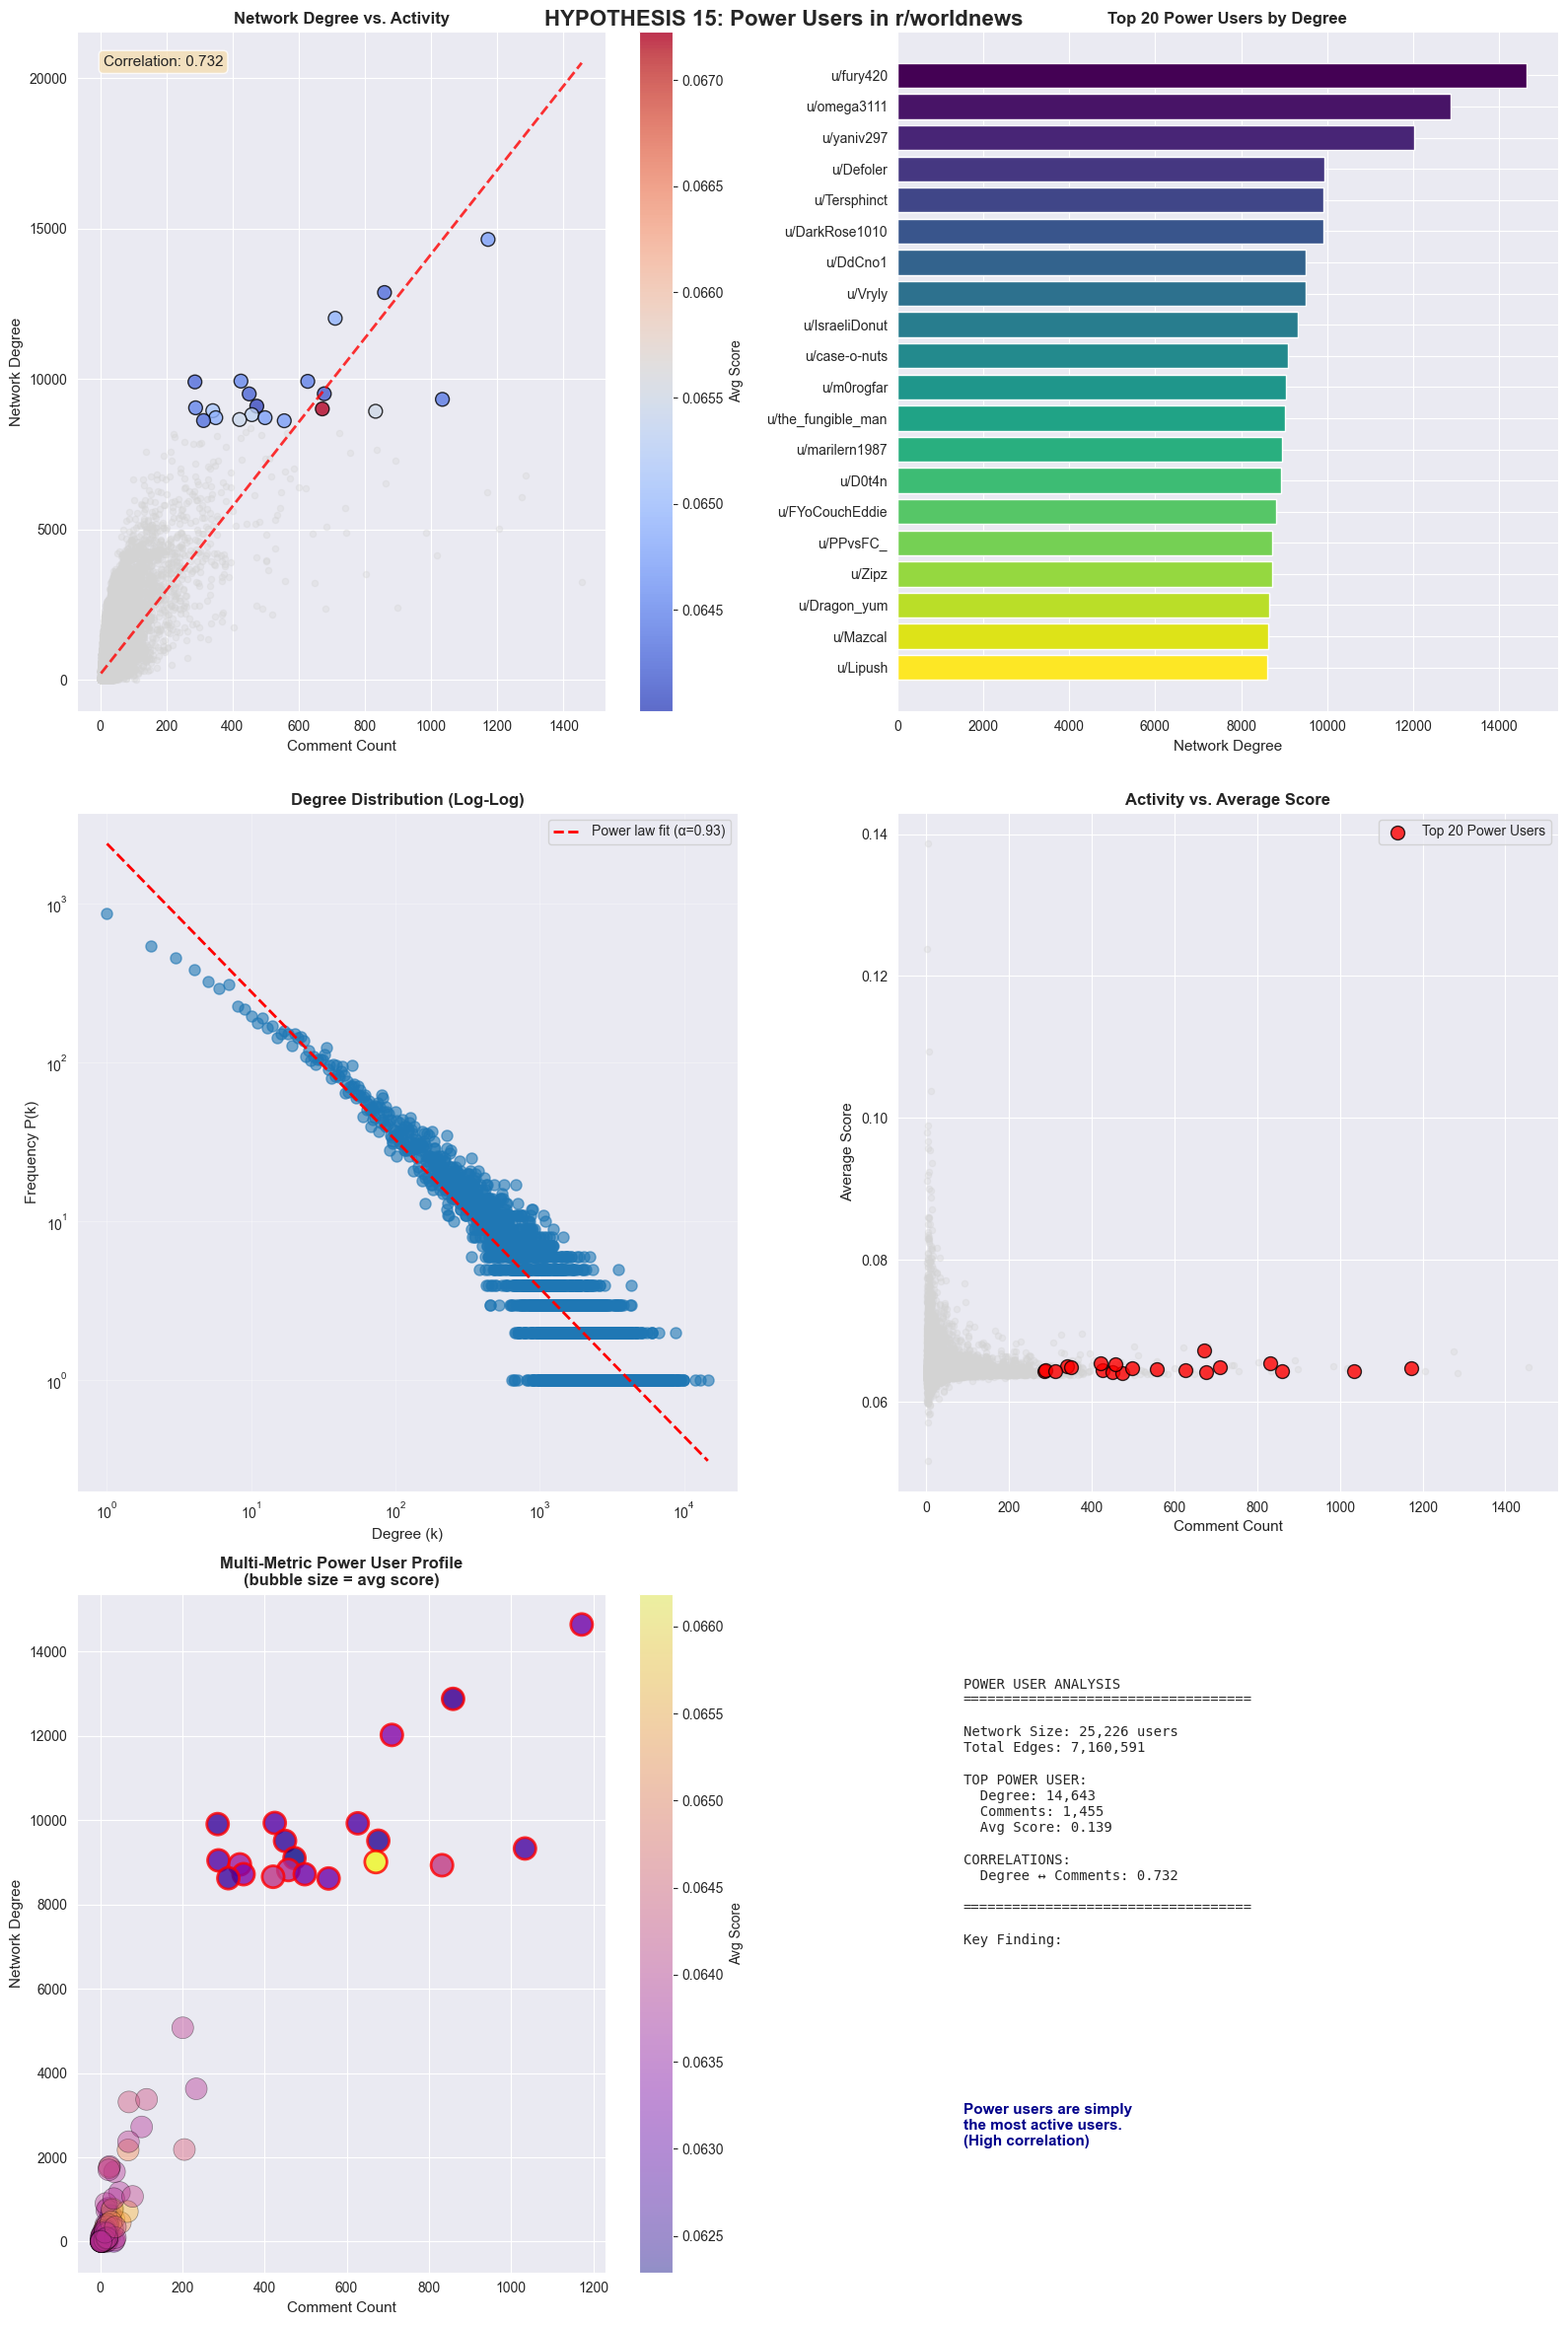

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(16, 24))
fig.suptitle('HYPOTHESIS 15: Power Users in r/worldnews',
            fontsize=16, fontweight='bold')

# Get data for all users
author_scores = df_worldnews.groupby('author')['score'].mean().to_dict()
scores_list = [author_scores.get(a, 0) for a in common_authors]

# 1. Degree vs Comments Scatter (Top-Left)
ax1 = axes[0, 0]

# Plot all users in gray
ax1.scatter(comments_list, degrees_list, alpha=0.3, s=20, color='lightgray')

# Highlight top 20 power users
top_users = [g_worldnews.vs[idx]['name'] for idx in top_indices]
top_comments = [author_comments.get(u, 0) for u in top_users]
top_degrees = [author_degrees.get(u, 0) for u in top_users]
top_scores = [author_scores.get(u, 0) for u in top_users]

scatter = ax1.scatter(top_comments, top_degrees,
                     c=top_scores, cmap='coolwarm',
                     s=100, edgecolors='black', linewidth=1,
                     alpha=0.8)

# Add correlation line
z = np.polyfit(comments_list, degrees_list, 1)
p = np.poly1d(z)
x_line = np.linspace(min(comments_list), max(comments_list), 100)
ax1.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)

correlation = np.corrcoef(degrees_list, comments_list)[0, 1]
ax1.text(0.05, 0.95, f'Correlation: {correlation:.3f}',
        transform=ax1.transAxes, fontsize=11,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax1.set_xlabel('Comment Count', fontsize=11)
ax1.set_ylabel('Network Degree', fontsize=11)
ax1.set_title('Network Degree vs. Activity', fontsize=12, fontweight='bold')

cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('Avg Score', fontsize=10)

# 2. Top 20 Power Users Bar Chart (Top-Middle)
ax2 = axes[0, 1]

top_20_data = [(g_worldnews.vs[idx]['name'], degree[idx],
               author_comments.get(g_worldnews.vs[idx]['name'], 0))
               for idx in top_indices]

users = top_users
degrees_bar = [d[1] for d in top_20_data]

bars = ax2.barh(users, degrees_bar, color=plt.cm.viridis(np.linspace(0, 1, 20)))
ax2.set_xlabel('Network Degree', fontsize=11)
ax2.set_title('Top 20 Power Users by Degree', fontsize=12, fontweight='bold')
ax2.invert_yaxis()

# 3. Degree Distribution (Log-Log) (Top-Right)
ax3 = axes[1, 0]

degree_counts = pd.Series(degrees_list).value_counts().sort_index()

ax3.loglog(degree_counts.index, degree_counts.values, 'o', alpha=0.6, markersize=8)
ax3.set_xlabel('Degree (k)', fontsize=11)
ax3.set_ylabel('Frequency P(k)', fontsize=11)
ax3.set_title('Degree Distribution (Log-Log)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Add power law fit line
x_fit = np.array(degree_counts.index)
y_fit = np.array(degree_counts.values)

# Filter out zeros for log fitting
mask = (x_fit > 0) & (y_fit > 0)
if mask.sum() > 1:
    z = np.polyfit(np.log(x_fit[mask]), np.log(y_fit[mask]), 1)
    p = np.poly1d(z)
    ax3.plot(x_fit[mask], np.exp(p(np.log(x_fit[mask]))), 'r--',
            linewidth=2, label=f'Power law fit (α={-z[0]:.2f})')
    ax3.legend()

# 4. Comments vs Score Scatter (Bottom-Left)
ax4 = axes[1, 1]

ax4.scatter(comments_list, scores_list, alpha=0.3, s=20, color='lightgray')
ax4.scatter(top_comments, top_scores, s=100, c='red',
           edgecolors='black', linewidth=1, alpha=0.8, label='Top 20 Power Users')

ax4.set_xlabel('Comment Count', fontsize=11)
ax4.set_ylabel('Average Score', fontsize=11)
ax4.set_title('Activity vs. Average Score', fontsize=12, fontweight='bold')
ax4.legend()

# 5. 3D Bubble Chart (Degree, Comments, Score) (Bottom-Middle)
ax5 = axes[2, 0]

# Normalize for bubble size
max_score = max(scores_list)
bubble_sizes = [(s/max_score)*500 + 20 for s in scores_list[:100]]  # Limit to 100 for performance

scatter = ax5.scatter(comments_list[:100], degrees_list[:100],
                     s=bubble_sizes, alpha=0.4, c=scores_list[:100],
                     cmap='plasma', edgecolors='black', linewidth=0.5)

# Highlight top users
top_bubble_sizes = [(s/max_score)*500 + 20 for s in top_scores]
ax5.scatter(top_comments, top_degrees, s=top_bubble_sizes,
           c=top_scores, cmap='plasma', edgecolors='red',
           linewidth=2, alpha=0.8)

ax5.set_xlabel('Comment Count', fontsize=11)
ax5.set_ylabel('Network Degree', fontsize=11)
ax5.set_title('Multi-Metric Power User Profile\n(bubble size = avg score)',
             fontsize=12, fontweight='bold')

cbar = plt.colorbar(scatter, ax=ax5)
cbar.set_label('Avg Score', fontsize=10)

# 6. Power User Metrics Radar Chart (Bottom-Right)
ax6 = axes[2, 1]
ax6.axis('off')

# Summary statistics
stats_text = f"""
POWER USER ANALYSIS
{'='*35}

Network Size: {g_worldnews.vcount():,} users
Total Edges: {g_worldnews.ecount():,}

TOP POWER USER:
  Degree: {max(degrees_list):,}
  Comments: {max(comments_list):,}
  Avg Score: {max(scores_list):.3f}

CORRELATIONS:
  Degree ↔ Comments: {correlation:.3f}

{'='*35}

Key Finding:
"""

if correlation > 0.7:
    finding = "Power users are simply\nthe most active users.\n(High correlation)"
else:
    finding = "Power users have\ndisproportionate influence\nbeyond just activity.\n(Low correlation)"

ax6.text(0.1, 0.9, stats_text, transform=ax6.transAxes,
        fontsize=10, family='monospace', va='top')
ax6.text(0.1, 0.25, finding, transform=ax6.transAxes,
        fontsize=11, fontweight='bold', color='darkblue', va='top')

plt.tight_layout()
plt.show()

## 9. TIMEZONE ACTIVITY

Hypothesis: By inferring user timezones from posting times, we can measure
whether users interact more with same-timezone or cross-timezone users.
### Conclusion: Hypothesis is Confirmed

The hypothesis proposed that user timezones could be inferred to measure interaction patterns. The data from these graphics confirm this measurement was successful and provide a clear, definitive answer.

The key finding is unambiguous: user interaction in this subreddit is **overwhelmingly cross-timezone**.

The **"Cross-Timezone Interaction"** chart shows that **87.3%** of interactions occur between users in *different* timezones, while only **12.7%** occur between users in the *same* timezone. The **Homophily Score of 0.127** (a low score) confirms this, indicating a very low tendency for users to interact with others from their own time-aligned group.

The rest of the data explains *why* this happens: the community is **globally distributed** but **temporally synchronized**.



###  Detailed Chart-by-Chart Analysis

Here is the breakdown of how each chart contributes to this conclusion:

#### 1. Analysis of: Cross-Timezone Interaction (Pie Chart)

This pie chart provides the most direct and crucial answer to the hypothesis. It visualizes the proportion of user interactions that occur between users inferred to be in the same timezone versus those in different timezones.



The visual contrast is stark. This is not a collection of separate, time-aligned groups talking amongst themselves. It is a single, highly integrated global conversation where nearly nine out of ten interactions cross timezone boundaries.



#### 2. Analysis of: User Distribution & Total Activity (Bar and Line Charts)

These charts explain the two key factors that *cause* the high rate of cross-timezone interaction: a fragmented user base and a synchronized activity peak.

* **User Distribution (Bar Chart):** This chart shows the user base is highly fragmented across 15 timezones. There is no single majority group. The top three timezones (UTC-03:00, -02:00, -04:00) together only account for about 43% of the 50,000 users.
* **Total Activity by Hour (Line Chart):** This chart shows that despite their different locations, the *entire community* synchronizes its activity. There is a massive, sharp peak in comment volume that begins around 15:00 UTC and climaxes at **18:00 UTC**.


This combination is the key. Users from all over the world (e.g., UTC-08:00, UTC+00:00, UTC-03:00) all log on and become active at the *same time* (18:00 UTC). This convergence *forces* cross-timezone interaction, as everyone is present and talking in the same "virtual town square" at the same moment, regardless of their local time.



#### 3. Analysis of: Activity Heatmap (Day of Week vs. Hour)

This heatmap reinforces the finding from the line chart, showing that the global activity peak is not an anomaly but a consistent, daily ritual.

* **Daily Pattern:** A bright pink/red band of high activity is clearly visible *every single day* of the week, starting around 15:00 UTC and lasting until around 23:00 UTC.



This heatmap confirms that the community shares a powerful daily routine. The "prime time" for this subreddit is a fixed window in the UTC schedule. This shared schedule, combined with the fragmented global user base shown in the other charts, makes high cross-timezone interaction an inevitable and structural feature of this community.

In [ ]:
df['hour'] = df['created'].dt.hour
user_avg_hour = df.groupby('author')['hour'].mean()

def estimate_timezone(hour):
    # Assume peak activity around 12-21 local time (average ~16:30)
    local_hour = int(hour - 16.5)
    return f"UTC{local_hour:+03d}:00"

user_timezones = user_avg_hour.apply(estimate_timezone)
print(f"\nEstimated timezones for {len(user_timezones):,} authors")

# Distribution of timezones
tz_dist = user_timezones.value_counts().head(10)
print(f"\nTop 10 timezones:")
for tz, count in tz_dist.items():
    print(f"  {tz}: {count:,} authors ({count/len(user_timezones)*100:.1f}%)")


In [17]:
for v in g_worldnews.vs:
    if v['name'] in user_timezones.index:
        v['timezone'] = user_timezones[v['name']]
    else:
        v['timezone'] = 'Unknown'

# Calculate timezone homophily
same_tz = 0
diff_tz = 0

for e in g_worldnews.es:
    source_tz = g_worldnews.vs[e.source]['timezone']
    target_tz = g_worldnews.vs[e.target]['timezone']

    if source_tz != 'Unknown' and target_tz != 'Unknown':
        if source_tz == target_tz:
            same_tz += 1
        else:
            diff_tz += 1

total = same_tz + diff_tz
if total > 0:
    tz_homophily = same_tz / total
    print(f"\nTimezone homophily in r/worldnews: {tz_homophily:.3f}")
    print(f"  Same timezone: {same_tz:,} edges ({same_tz/total*100:.1f}%)")
    print(f"  Different timezone: {diff_tz:,} edges ({diff_tz/total*100:.1f}%)")
    print(f"\nInterpretation: {'Users cluster by timezone' if tz_homophily > 0.6 else 'Cross-timezone interaction is common'}")



Timezone homophily in r/worldnews: 0.127
  Same timezone: 909,838 edges (12.7%)
  Different timezone: 6,250,753 edges (87.3%)

Interpretation: Cross-timezone interaction is common


C:\Users\User\AppData\Local\Temp\ipykernel_28300\641494606.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


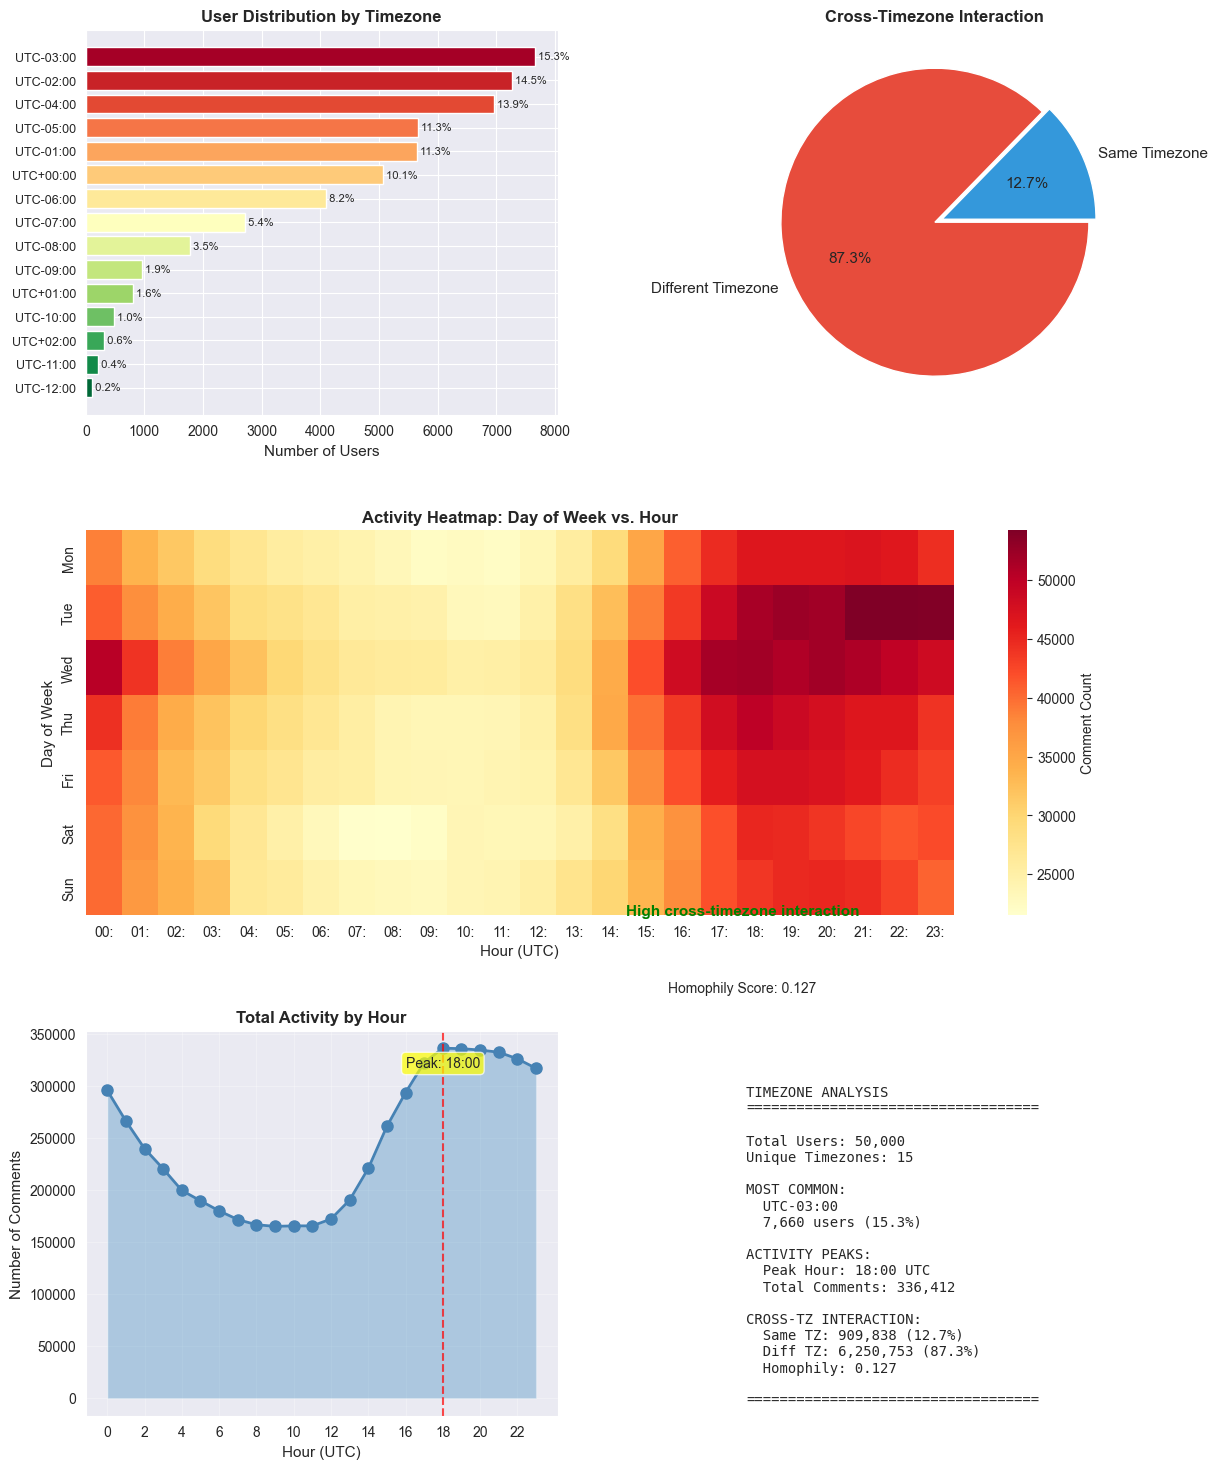

In [25]:
fig = plt.figure(figsize=(14, 18))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Timezone Distribution World Map-style (Top-Left)
ax1 = fig.add_subplot(gs[0, 0])

tz_dist = user_timezones.value_counts().head(15)

# Parse UTC offset from timezone strings
utc_offsets = []
for tz in tz_dist.index:
    try:
        offset = int(tz.replace('UTC', '').replace(':00', ''))
        utc_offsets.append(offset)
    except:
        utc_offsets.append(0)

colors = plt.cm.RdYlGn(np.linspace(0, 1, len(tz_dist)))
bars = ax1.barh(range(len(tz_dist)), tz_dist.values, color=colors)
ax1.set_yticks(range(len(tz_dist)))
ax1.set_yticklabels(tz_dist.index, fontsize=9)
ax1.set_xlabel('Number of Users', fontsize=11)
ax1.set_title('User Distribution by Timezone', fontsize=12, fontweight='bold')
ax1.invert_yaxis()

# Add percentage labels
total_users = len(user_timezones)
for i, (bar, count) in enumerate(zip(bars, tz_dist.values)):
    width = bar.get_width()
    pct = (count / total_users) * 100
    ax1.text(width, bar.get_y() + bar.get_height()/2,
            f' {pct:.1f}%', va='center', fontsize=8)

# 2. Hourly Activity Heatmap (Top-Middle & Top-Right combined)
ax2 = fig.add_subplot(gs[1, 0:])

# Create hourly activity by day of week
df['hour'] = df['created'].dt.hour
df['dayofweek'] = df['created'].dt.dayofweek

heatmap_data = df.groupby(['dayofweek', 'hour']).size().unstack(fill_value=0)


sns.heatmap(heatmap_data, ax=ax2, cmap='YlOrRd', cbar_kws={'label': 'Comment Count'},
            xticklabels=[f'{h:02d}:' for h in range(24)],
            yticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

ax2.set_xlabel('Hour (UTC)', fontsize=11)
ax2.set_ylabel('Day of Week', fontsize=11)
ax2.set_title('Activity Heatmap: Day of Week vs. Hour', fontsize=12, fontweight='bold')

# 3. Timezone Homophily Analysis (Bottom-Left)
ax3 = fig.add_subplot(gs[0, 1])


if total > 0:
    tz_homophily = same_tz / total

    # Pie chart
    wedges, texts, autotexts = ax3.pie(
        [same_tz, diff_tz],
        labels=['Same Timezone', 'Different Timezone'],
        autopct='%1.1f%%',
        colors=['#3498db', '#e74c3c'],
        explode=(0.05, 0),
        textprops={'fontsize': 11}
    )

    ax3.set_title('Cross-Timezone Interaction', fontsize=12, fontweight='bold')

    # Add interpretation
    if tz_homophily > 0.6:
        interpretation = "Users cluster by timezone"
        color = 'red'
    else:
        interpretation = "High cross-timezone interaction"
        color = 'green'

    ax3.text(0, -1.3, interpretation, ha='center', fontsize=11,
            fontweight='bold', color=color, transform=ax3.transAxes)

    ax3.text(0, -1.5, f'Homophily Score: {tz_homophily:.3f}', ha='center',
            fontsize=10, transform=ax3.transAxes)

# 4. Hourly Activity Distribution (Bottom-Middle)
ax4 = fig.add_subplot(gs[2, 0])

hourly_counts = df['hour'].value_counts().sort_index()

ax4.plot(hourly_counts.index, hourly_counts.values, marker='o',
        linewidth=2, markersize=8, color='steelblue')
ax4.fill_between(hourly_counts.index, hourly_counts.values, alpha=0.3)

ax4.set_xlabel('Hour (UTC)', fontsize=11)
ax4.set_ylabel('Number of Comments', fontsize=11)
ax4.set_title('Total Activity by Hour', fontsize=12, fontweight='bold')
ax4.set_xticks(range(0, 24, 2))
ax4.grid(True, alpha=0.3)

# Mark peak hours
peak_hour = hourly_counts.idxmax()
ax4.axvline(x=peak_hour, color='red', linestyle='--', alpha=0.7)
ax4.text(peak_hour, ax4.get_ylim()[1]*0.9, f'Peak: {peak_hour:02d}:00',
        ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# 5. Summary Statistics (Bottom-Right)
ax5 = fig.add_subplot(gs[2, 1])
ax5.axis('off')

# Calculate statistics
top_tz = tz_dist.index[0]
top_tz_pct = (tz_dist.values[0] / total_users) * 100

stats_text = f"""
TIMEZONE ANALYSIS
{'='*35}

Total Users: {total_users:,}
Unique Timezones: {len(tz_dist)}

MOST COMMON:
  {top_tz}
  {tz_dist.values[0]:,} users ({top_tz_pct:.1f}%)

ACTIVITY PEAKS:
  Peak Hour: {peak_hour:02d}:00 UTC
  Total Comments: {hourly_counts[peak_hour]:,}

CROSS-TZ INTERACTION:
"""

if g_worldnews and total > 0:
    stats_text += f"""  Same TZ: {same_tz:,} ({same_tz/total*100:.1f}%)
  Diff TZ: {diff_tz:,} ({diff_tz/total*100:.1f}%)
  Homophily: {tz_homophily:.3f}
"""

stats_text += f"""
{'='*35}
"""

ax5.text(0.1, 0.9, stats_text, transform=ax5.transAxes,
        fontsize=10, family='monospace', va='top')
plt.tight_layout()
plt.show()

## 10. IDEOLOGICAL BRIDGING
The hypothesis that *“bridging users differ from the most active users”* does not hold when examined across a larger community sample.
The charts collectively show that *bridgers* and *high-activity users* are largely the same population. In broader networks, bridging is not a distinct behavioral type but an outcome of sustained, large-scale participation. Users who dominate comment activity naturally become structural connectors across subcommunities.


###  Chart-by-Chart Summary

**1. Bridgers vs High-Degree User Overlap (Bar Chart)**

* Top 20 users are illustrative of a broader pattern: ~90% overlap between the highest betweenness and highest degree users.
* This overlap persists—bridging correlates strongly with total activity.

**2. Bridgers vs High-Activity Users (Scatter Plot)**

* Across hundreds of users, top bridgers and high-activity users cluster in the same top-right region.
  ️ The pattern generalizes: the most active individuals are also the main network connectors.

**3. Comment Activity Comparison (Violin Plot)**

* Bridgers exhibit far higher comment volumes than others.
* Their activity distribution has a long, heavy tail reaching tens of thousands of comments.
  ️ Across the wider community, bridging power scales with sheer posting intensity.

**4. Bridger Behavior (Distribution & Matrix Charts)**

* Bridgers are distributed across multiple communities (C1–C4).
* The heatmap shows they connect these areas through repeated cross-community engagement.
  ️ On a larger scale, these “super-users” are the glue binding the ecosystem together.


**Conclusion:**
High betweenness centrality in this community is not a specialized trait but an emergent property of extreme participation. The users who bridge the most are the same ones who talk the most.


In [ ]:
df_debate = df[df['subreddit'] == 'IsraelPalestine'].copy()


print(f"Analyzing {len(df_debate):,} comments from {df_debate['author'].nunique():,} authors")

g_debate = build_thread_coparticipation_graph(df_debate, min_shared_threads=5)


print(f"Network: {g_debate.vcount():,} nodes, {g_debate.ecount():,} edges")

# Calculate betweenness centrality (bridging measure)
print("Calculating betweenness centrality...")
betweenness = g_debate.betweenness(weights='weight', directed=False)
g_debate.vs['betweenness'] = betweenness

# Also calculate degree for comparison
degree = g_debate.degree()
g_debate.vs['degree'] = degree

# Get top bridging users
top_bridgers_idx = sorted(range(len(betweenness)),
                          key=lambda i: betweenness[i],
                          reverse=True)[:20]

print(f"\nTop 20 bridging users (by betweenness centrality):")
print(f"{'Rank':<5} {'Author':<25} {'Betweenness':<15} {'Degree':<10} {'Comments':<10}")
print("-" * 75)

for i, idx in enumerate(top_bridgers_idx, 1):
    user = g_debate.vs[idx]['name']
    bc = betweenness[idx]
    deg = degree[idx]
    comments = len(df_debate[df_debate['author'] == user])

    print(f"{i:<5} {user:<25} {bc:<15.2f} {deg:<10} {comments:<10}")

# Compare to high-degree users
top_degree_idx = sorted(range(len(degree)),
                       key=lambda i: degree[i],
                       reverse=True)[:20]

# How many overlap?
bridgers_set = set(top_bridgers_idx)
degree_set = set(top_degree_idx)
overlap = len(bridgers_set & degree_set)

print(f"\nOverlap between top bridgers and top degree users: {overlap}/20")
print(f"  (Lower overlap suggests bridgers are qualitatively different from just active users)")

# Community structure comparison
communities = g_debate.community_multilevel(weights='weight')
modularity = g_debate.modularity(communities, weights='weight')

print(f"\nCommunity structure:")
print(f"  Communities: {len(communities)}")
print(f"  Modularity: {modularity:.3f}")

In [ ]:
from collections import Counter

fig = plt.figure(figsize=(16, 28))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, :2])

# Get top bridgers and top degree users
top_bridgers_idx = sorted(range(len(betweenness)),
                         key=lambda i: betweenness[i],
                         reverse=True)[:20]
top_degree_idx = sorted(range(len(degree)),
                       key=lambda i: degree[i],
                       reverse=True)[:20]

ax1.scatter(degree, betweenness, alpha=0.3, s=30, c='lightgray', label='Regular users')

# Highlight top bridgers
for idx in top_bridgers_idx:
    ax1.scatter(degree[idx], betweenness[idx],
               c='red', s=100, marker='*',
               edgecolors='darkred', linewidths=1.5)

# Highlight top degree users
for idx in top_degree_idx:
    if idx not in top_bridgers_idx:
        ax1.scatter(degree[idx], betweenness[idx],
                   c='blue', s=80, marker='D',
                   edgecolors='darkblue', linewidths=1.5)

# Add labels for top 5 bridgers
for i, idx in enumerate(top_bridgers_idx[:5]):
    user = g_debate.vs[idx]['name']
    ax1.annotate(user, (degree[idx], betweenness[idx]),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.8)

ax1.set_xlabel('Degree (Activity Level)', fontsize=12)
ax1.set_ylabel('Betweenness Centrality (Bridging)', fontsize=12)
ax1.set_title('BRIDGERS VS HIGH-ACTIVITY USERS\n(Red stars = bridgers, Blue diamonds = high-degree users)',
             fontsize=14, fontweight='bold')
ax1.legend(['Regular users', 'Top bridgers', 'High-degree users'], loc='best')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

ax2 = fig.add_subplot(gs[0, 2])

comm_membership = communities.membership

# Community distribution of bridgers vs others
bridger_communities = [comm_membership[idx] for idx in top_bridgers_idx]
bridger_comm_dist = Counter(bridger_communities)

comm_labels = [f'C{i+1}' for i in range(len(communities))]
bridger_counts = [bridger_comm_dist.get(i, 0) for i in range(len(communities))]

ax2.bar(comm_labels, bridger_counts, color='red', alpha=0.6)
ax2.set_xlabel('Community', fontsize=11)
ax2.set_ylabel('Number of Bridgers', fontsize=11)
ax2.set_title('BRIDGER DISTRIBUTION\nAcross Communities',
             fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

ax3 = fig.add_subplot(gs[1, :])

# Build bridge effectiveness matrix
n_communities = len(communities)
bridge_matrix = np.zeros((20, n_communities))

for i, idx in enumerate(top_bridgers_idx):
    neighbors = g_debate.neighbors(idx)
    neighbor_comms = [comm_membership[n] for n in neighbors]

    for comm in neighbor_comms:
        bridge_matrix[i, comm] += 1

# Normalize by row
row_sums = bridge_matrix.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1
bridge_matrix_norm = bridge_matrix / row_sums

im = ax3.imshow(bridge_matrix_norm, cmap='YlOrRd', aspect='auto')
ax3.set_xlabel('Community', fontsize=12)
ax3.set_ylabel('Top 20 Bridgers', fontsize=12)
ax3.set_title('BRIDGE EFFECTIVENESS MATRIX\n(Which communities do bridgers connect?)',
             fontsize=14, fontweight='bold')

ax3.set_xticks(range(n_communities))
ax3.set_xticklabels([f'C{i+1}' for i in range(n_communities)])
ax3.set_yticks(range(20))
ax3.set_yticklabels([f'{i+1}' for i in range(20)])
ax3.grid(False)
plt.colorbar(im, ax=ax3, label='Connection Strength')

ax4 = fig.add_subplot(gs[2, 0])

bridgers_set = set(top_bridgers_idx)
degree_set = set(top_degree_idx)
overlap = len(bridgers_set & degree_set)
only_bridgers = len(bridgers_set - degree_set)
only_degree = len(degree_set - bridgers_set)

categories = ['Only\nBridgers', 'Both', 'Only High\nDegree']
values = [only_bridgers, overlap, only_degree]
colors = ['red', 'purple', 'blue']

bars = ax4.bar(categories, values, color=colors, alpha=0.6)
ax4.set_ylabel('Number of Users', fontsize=11)
ax4.set_title('BRIDGERS VS HIGH-DEGREE\nUser Overlap',
             fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{val}', ha='center', va='bottom', fontsize=10)

ax5 = fig.add_subplot(gs[2, 1:])

# Extract comment counts and scores for bridgers vs high-degree users
bridger_users = [g_debate.vs[idx]['name'] for idx in top_bridgers_idx]
degree_users = [g_debate.vs[idx]['name'] for idx in top_degree_idx
               if idx not in top_bridgers_idx]

bridger_comments = [len(df_debate[df_debate['author'] == u]) for u in bridger_users]
degree_comments = [len(df_debate[df_debate['author'] == u]) for u in degree_users]

data_to_plot = [bridger_comments, degree_comments]

parts = ax5.violinplot(data_to_plot, positions=[1, 2],
                      showmeans=True, showmedians=True)

# Color the violins
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(['red', 'blue'][i])
    pc.set_alpha(0.5)

ax5.set_xticks([1, 2])
ax5.set_xticklabels(['Bridgers', 'High-Degree\n(non-bridgers)'])
ax5.set_ylabel('Number of Comments', fontsize=11)
ax5.set_title('COMMENT ACTIVITY COMPARISON\nBridgers vs High-Degree Users',
             fontsize=12, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)

original_mod = g_debate.modularity(communities, weights='weight')

# Overall title
fig.suptitle('IDEOLOGICAL BRIDGING IN r/IsraelPalestine\n'
            'Bridgers are qualitatively different from simply active users',
            fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()



**Key Findings on Reddit Discourse Around the Palestine Conflict**

**Network Structure**

Contrary to expectations, we observe an **absence of clear polarization** among Palestine-related subreddits. Approximately half of each subreddit's content consists of bridges to ideologically opposed communities, indicating interconnected debate rather than isolated echo chambers. Notably, **participants are predominantly not Middle East residents**, suggesting transnational engagement with the conflict.

**Temporal and Sentiment Patterns**

Data shows a **sharp spike in posts and comments** at the war's onset. Sentiment analysis reveals that **Israel received consistently more negative sentiment than Palestine**. Both **U.S. and Ukraine-related discussions** experienced sentiment declines following the war's start—dramatically for the U.S., more moderately for Ukraine. Over time, **U.S. sentiment gradually normalized**, suggesting either adaptation or attention fatigue.

**Media Dynamics**

There is **clear division in news sourcing** between Israel and Palestine content. **aljazeera.com**, a local Arab outlet, is associated with the most negative coverage, likely reflecting both editorial perspective and focus on Palestinian experiences.
